In [1]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
import s3fs
import fastparquet
import awswrangler as wr
import os

import pyarrow.parquet as pq
import pyarrow as pa

In [2]:
# LEEMOS EL FICHERO CON LA COMPOSICIÓN HISTORICA
ibex_constituents = pd.read_excel('data_processing/Historical Composition IBEX35.xlsx')
ibex_constituents.head()

Activo  Inclusion  Exclusion
0    ACE 1991-01-02 2003-06-02
1    ACX 1991-01-02 1991-07-01
2    ALB 1991-01-02 1991-07-01
3    ASL 1991-01-02 1994-01-03
4    BBV 1991-01-02 2000-01-31

In [207]:
# OBTENEMOS EL DIA ACTUAL
today = datetime.date.today().strftime('%d/%m/%Y')

# COMPLETAMOS LOS DATOS NULOS EN EL FICHERO DE COMPOSICIÓN HISTORICA CON LA FECHA ACTUAL
ibex_constituents.fillna('today',inplace=True)

# DEFINIMOS UNA VARIABLE PARA TODOS LOS ACTIVOS
activos = ibex_constituents.Activo
ibex_constituents['Ticker'] = activos.apply(lambda x: x.split('_')[0])

unique_activos = list(set(activos))

### PRUEBA CON API DE MARKETSTACK 

In [183]:
url = 'http://api.marketstack.com/v1/exchanges?access_key=3aebb6cbc9c7a1a5228168674c5153a5'
response = requests.get(url).content


In [185]:
# INTENTAMOS OBTENER TODOS LOS EXCHANGES
import requests
import json
from io import BytesIO
# API_TOKEN = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'


url = f'http://api.marketstack.com/v1/'
exchange_list = 'exchanges'
# se hace una llamada GET a la API con la URL indicada y los parámetros necesarios
r = requests.get(url+exchange_list,params={
    'access_key':API_TOKEN
    })
# print(r.content)
# se genera un dataframe con los datos de la consulta
exchanges = pd.DataFrame(json.load(BytesIO(r.content))['data'])
exchanges


name   acronym   mic    country country_code  \
0         NASDAQ Stock Exchange    NASDAQ  XNAS        USA           US   
1       New York Stock Exchange      NYSE  XNYS        USA           US   
2                     NYSE ARCA  NYSEARCA  ARCX        USA           US   
3                   OTC Markets            OTCM        USA           US   
4   Buenos Aires Stock Exchange      BCBA  XBUE  Argentina           AR   
..                          ...       ...   ...        ...          ...   
64            OTCQB Marketplace     OTCQB  OTCB        USA           US   
65            OTCQX Marketplace     OTCQX  OTCQ        USA           US   
66             OTC PINK current      PINK  PINC        USA           US   
67           Investors Exchange       IEX  IEXG        USA           US   
68                        INDEX      None  INDX       None         INDX   

            city              website  \
0       New York       www.nasdaq.com   
1       New York         www.nyse.com   
2       New York         www.nyse.com   
3       New York   www.otcmarkets.com   
4   Buenos Aires  www.bcba.sba.com.ar   
..           ...                  ...   
64      New York   www.otcmarkets.com   
65      New York   www.otcmarkets.com   
66      New York   www.otcmarkets.com   
67      New York   www.iextrading.com   
68          None                        

                                             timezone  \
0   {'timezone': 'America/New_York', 'abbr': 'EST'...   
1   {'timezone': 'America/New_York', 'abbr': 'EST'...   
2   {'timezone': 'America/New_York', 'abbr': 'EST'...   
3   {'timezone': 'America/New_York', 'abbr': 'EST'...   
4   {'timezone': 'America/Argentina/Buenos_Aires',...   
..                                                ...   
64  {'timezone': 'America/New_York', 'abbr': 'EST'...   
65  {'timezone': 'America/New_York', 'abbr': 'EST'...   
66  {'timezone': 'America/New_York', 'abbr': 'EST'...   
67  {'timezone': 'America/New_York', 'abbr': 'EST'...   
68                                               None   

                                             currency  
0   {'code': 'USD', 'symbol': '$', 'name': 'US Dol...  
1   {'code': 'USD', 'symbol': '$', 'name': 'US Dol...  
2   {'code': 'USD', 'symbol': '$', 'name': 'US Dol...  
3   {'code': 'USD', 'symbol': '$', 'name': 'US Dol...  
4   {'code': 'ARS', 'symbol': 'AR$', 'name': 'Arge...  
..                                                ...  
64  {'code': 'USD', 'symbol': '$', 'name': 'US Dol...  
65  {'code': 'USD', 'symbol': '$', 'name': 'US Dol...  
66  {'code': 'USD', 'symbol': '$', 'name': 'US Dol...  
67  {'code': 'USD', 'symbol': '$', 'name': 'US Dol...  
68                                               None  

[69 rows x 9 columns]

In [186]:
spain_ex_code = exchanges.loc[exchanges['country']=='Spain','mic'].values[0]

symbol_list = 'tickers'

# se hace una llamada GET a la API con la URL indicada y los parámetros necesarios
r = requests.get(url+symbol_list,
                 params={
                    'access_key': API_TOKEN,
                    'exchange': spain_ex_code,
                    'limit':1000
                    }
                )
# print(r.content)
# se genera un dataframe con los datos de la consulta
symbols = pd.DataFrame(json.load(BytesIO(r.content))['data'])
# json.load(BytesIO(r.content))

symbols


name      symbol  \
0            INDUSTRIA DE DISEO TEXTIL S.A. INDITEX-    ITX.BMEX   
1                                             AIRBUS    AIR.BMEX   
2    PETROLEO BRASILEIRO,S.A. -PETROBRAS- ORDINARIAS   XPBR.BMEX   
3                                 ACCIONES IBERDROLA    IBE.BMEX   
4                               BANCO SANTANDER S.A.    SAN.BMEX   
..                                               ...         ...   
304                 Silicius Real Estate SOCIMI S.A.   YSIL.BMEX   
305                    Tempore Properties SOCIMI SAU   YTEM.BMEX   
306         Urban View Development Spain SOCIMI S.A.   YUVS.BMEX   
307                    Veracruz Properties SOCIMI SA   YVCP.BMEX   
308  Lyxor Ibex 35 Doble Apalancado Diario UCITS ETF  IBEXA.BMEX   

     has_intraday  has_eod country  \
0           False     True    None   
1           False     True    None   
2           False    False    None   
3           False     True    None   
4           False     True    None   
..            ...      ...     ...   
304         False     True   Spain   
305         False     True   Spain   
306         False     True   Spain   
307         False     True   Spain   
308         False     True   Spain   

                                        stock_exchange  
0    {'name': 'Bolsas y Mercados Españoles', 'acron...  
1    {'name': 'Bolsas y Mercados Españoles', 'acron...  
2    {'name': 'Bolsas y Mercados Españoles', 'acron...  
3    {'name': 'Bolsas y Mercados Españoles', 'acron...  
4    {'name': 'Bolsas y Mercados Españoles', 'acron...  
..                                                 ...  
304  {'name': 'Bolsas y Mercados Españoles', 'acron...  
305  {'name': 'Bolsas y Mercados Españoles', 'acron...  
306  {'name': 'Bolsas y Mercados Españoles', 'acron...  
307  {'name': 'Bolsas y Mercados Españoles', 'acron...  
308  {'name': 'Bolsas y Mercados Españoles', 'acron...  

[309 rows x 6 columns]

In [202]:
complete_list = set(symbols.symbol.apply(lambda x: x.replace('.BMEX','')))

In [ ]:
def get_data()

In [198]:
eod_data = 'eod'

# se hace una llamada GET a la API con la URL indicada y los parámetros necesarios
r = requests.get(url+eod_data,
                 params={
                    'access_key': API_TOKEN,
                    'exchange': spain_ex_code,
                    'symbols':ticker,
                    'date_from': ibex_constituents.loc[ibex_constituents['Activo']=='SAN']['Inclusion'],
                    'date_to': ibex_constituents.loc[ibex_constituents['Activo']=='SAN']['Exclusion'],
                    'limit':1000
                    }
                )
print(r.content)
# se genera un dataframe con los datos de la consulta
ticker_data = pd.DataFrame(json.load(BytesIO(r.content))['data'])

b'{"pagination":{"limit":1000,"offset":0,"count":105,"total":105},"data":[{"open":84.0885,"high":84.0885,"low":82.337,"close":84.0885,"volume":489622.73,"adj_high":null,"adj_low":null,"adj_close":0.5113,"adj_open":null,"adj_volume":null,"split_factor":1.0,"dividend":0.0,"symbol":"ZOT.BMEX","exchange":"BMEX","date":"1994-01-03T00:00:00+0000"},{"open":81.7392,"high":84.0885,"low":81.7392,"close":81.7392,"volume":1887356.68,"adj_high":null,"adj_low":null,"adj_close":0.497,"adj_open":null,"adj_volume":null,"split_factor":1.0,"dividend":0.0,"symbol":"ZOT.BMEX","exchange":"BMEX","date":"1993-12-31T00:00:00+0000"},{"open":83.5425,"high":84.678,"low":83.5425,"close":83.5425,"volume":232997.66,"adj_high":null,"adj_low":null,"adj_close":0.5079,"adj_open":null,"adj_volume":null,"split_factor":1.0,"dividend":0.0,"symbol":"ZOT.BMEX","exchange":"BMEX","date":"1993-12-30T00:00:00+0000"},{"open":84.678,"high":84.7424,"low":83.5425,"close":84.678,"volume":555338.4,"adj_high":null,"adj_low":null,"adj_cl

In [319]:
import math
for i in range(ibex_constituents.shape[0]):
    ticker = ibex_constituents.Ticker[i] + '.BMEX'
    start_date = ibex_constituents.Inclusion[i]
    end_date = ibex_constituents.Exclusion[i]
    print(start_date,end_date)
    total_days = (end_date.to_period('D') - start_date.to_period('D')).n/1000
    for _ in range(math.ceil(total_days)):
        prov_end_date = start_date + datetime.timedelta(days=1000)
        if prov_end_date > end_date:
            print(start_date, end_date, ticker)
        else:
            print(start_date, prov_end_date, ticker)
        start_date = prov_end_date

1991-01-02 00:00:00 2003-06-02 00:00:00
1991-01-02 00:00:00 1993-09-28 00:00:00 ACE.BMEX
1993-09-28 00:00:00 1996-06-24 00:00:00 ACE.BMEX
1996-06-24 00:00:00 1999-03-21 00:00:00 ACE.BMEX
1999-03-21 00:00:00 2001-12-15 00:00:00 ACE.BMEX
2001-12-15 00:00:00 2003-06-02 00:00:00 ACE.BMEX
1991-01-02 00:00:00 1991-07-01 00:00:00
1991-01-02 00:00:00 1991-07-01 00:00:00 ACX.BMEX
1991-01-02 00:00:00 1991-07-01 00:00:00
1991-01-02 00:00:00 1991-07-01 00:00:00 ALB.BMEX
1991-01-02 00:00:00 1994-01-03 00:00:00
1991-01-02 00:00:00 1993-09-28 00:00:00 ASL.BMEX
1993-09-28 00:00:00 1994-01-03 00:00:00 ASL.BMEX
1991-01-02 00:00:00 2000-01-31 00:00:00
1991-01-02 00:00:00 1993-09-28 00:00:00 BBV.BMEX
1993-09-28 00:00:00 1996-06-24 00:00:00 BBV.BMEX
1996-06-24 00:00:00 1999-03-21 00:00:00 BBV.BMEX
1999-03-21 00:00:00 2000-01-31 00:00:00 BBV.BMEX
1991-01-02 00:00:00 2023-08-03 15:50:12.462724
1991-01-02 00:00:00 1993-09-28 00:00:00 BKT.BMEX
1993-09-28 00:00:00 1996-06-24 00:00:00 BKT.BMEX
1996-06-24 00:00:0

In [320]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE MARKETSTACK Y LOS CARGAMOS EN UN BUCKET DE S3
s3 = boto3.resource('s3')

for i in range(ibex_constituents.shape[0]):

    try:
        ticker = ibex_constituents.Ticker[i] + '.BMEX'
        file_name = ibex_constituents.Activo[i] +'.parquet'
        start_date = ibex_constituents.Inclusion[i]
        end_date = ibex_constituents.Exclusion[i]
        full_path = raw_folder + file_name

        total_days = (end_date.to_period('D') - start_date.to_period('D')).n/1000

        stock_data = pd.DataFrame()

        for _ in range(math.ceil(total_days)):
            prov_end_date = start_date + datetime.timedelta(days=1000)
            if prov_end_date > end_date:
                r = requests.get(url+eod_data,
                        params={
                            'access_key': API_TOKEN,
                            'exchange': spain_ex_code,
                            'symbols':ticker,
                            'date_from': start_date,
                            'date_to': end_date,
                            'limit':1000
                            }
                        )
            else:
                r = requests.get(url+eod_data,
                        params={
                            'access_key': API_TOKEN,
                            'exchange': spain_ex_code,
                            'symbols':ticker,
                            'date_from': start_date,
                            'date_to': prov_end_date,
                            'limit': 1000
                            }
                        )
            
            # stock = yf.download(ticker)
            # stock = pd.DataFrame(stock)

            ticker_data = pd.DataFrame(json.load(BytesIO(r.content))['data'])
            stock_data = pd.concat([stock_data, ticker_data], axis=0)
            start_date = prov_end_date

        table = pa.Table.from_pandas(stock_data)
        buf = BytesIO()
        pq.write_table(table, buf)

        s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
        print(ticker)
    except:
        failed_loads.append(ticker)
        continue

ACX.BMEX
ALB.BMEX
ECR.BMEX
ELE.BMEX
MAP.BMEX
SAN.BMEX
VIS.BMEX
MVC.BMEX
ALB.BMEX
ACX.BMEX
FCC.BMEX
ALB.BMEX
ZOT.BMEX
ENC.BMEX
AMP.BMEX
SOL.BMEX
UNI.BMEX
ANA.BMEX
TUB.BMEX
VIS.BMEX
ALB.BMEX
ANA.BMEX
NHH.BMEX
AMS.BMEX
REE.BMEX
PRS.BMEX
MVC.BMEX
MAP.BMEX
PRS.BMEX
TL5.BMEX
REE.BMEX
NHH.BMEX
NHH.BMEX
COL.BMEX
BME.BMEX
ABG.BMEX
TRE.BMEX
OHLA.BMEX
EBRO.BMEX
BKIA.BMEX
DIA.BMEX
ABG.P.BMEX
VIS.BMEX
EBRO.BMEX
SCYR.BMEX
BKIA.BMEX
ABG.P.BMEX
VIS.BMEX
SGRE.BMEX
CIE.BMEX
ENC.BMEX
MAS.BMEX
ALM.BMEX
PHM.BMEX


In [150]:
tickers = set(activos)
available_tickers = complete_list.intersection(tickers)

In [148]:
tickers - complete_list

{'A3TV',
 'ABE',
 'ACE',
 'ACR',
 'AGR',
 'AGS',
 'ALT',
 'ARA',
 'ARG',
 'ASL',
 'AUM',
 'AZC',
 'BBV',
 'BCH',
 'BTO',
 'CAN',
 'CAR',
 'CEN',
 'CEP',
 'CIN',
 'CRF',
 'CRI',
 'CTE',
 'CTF',
 'CTG',
 'CUB',
 'DRC',
 'EBA',
 'EVA',
 'EXT',
 'FAD',
 'FEC',
 'FOC',
 'GAM',
 'GAS',
 'GES',
 'GPP',
 'HHU',
 'HID',
 'HIS',
 'IBLA',
 'IBR',
 'JAZ',
 'LOR',
 'PMD',
 'POP',
 'PRY',
 'PUL',
 'RAD',
 'SAR',
 'SCH',
 'SEV',
 'SGC',
 'SYV',
 'TAB',
 'TEM',
 'TPI',
 'TPZ',
 'TRR',
 'UNF',
 'URA',
 'URB',
 'VAL',
 'VDR',
 'ZEL'}

In [152]:
len(available_tickers), len(tickers)

(62, 127)

### LEEMOS LOS DATOS DE UN FICHERO PICKLE

In [6]:
import pickle
with open('./Datos TFM/stock_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
close_series = {ticker: df.close
                for ticker, df in data.items()}
stock_df = pd.DataFrame(close_series)

In [172]:
stock_df

SAN  BTO_1  BKIA_0    BKIA       NTGY  TRE     ACX_0    ACX  \
2003-01-02  2.251615    NaN     NaN     NaN   7.363463  NaN  4.761374    NaN   
2003-01-03  2.166648    NaN     NaN     NaN   7.270788  NaN  4.865828    NaN   
2003-01-07  2.251615    NaN     NaN     NaN   7.388738  NaN  4.778783    NaN   
2003-01-08  2.251615    NaN     NaN     NaN   7.582514  NaN  4.717851    NaN   
2003-01-09  2.251615    NaN     NaN     NaN   7.641489  NaN  4.752669    NaN   
...              ...    ...     ...     ...        ...  ...       ...    ...   
2020-08-17  1.890800    NaN     NaN  1.1240  16.160000  NaN       NaN  7.466   
2020-08-18  1.877000    NaN     NaN  1.1125  16.075000  NaN       NaN  7.318   
2020-08-19  1.934200    NaN     NaN  1.1260  16.300000  NaN       NaN  7.280   
2020-08-20  1.853800    NaN     NaN  1.0920  16.335000  NaN       NaN  6.950   
2020-08-21  1.827200    NaN     NaN  1.0540  16.050000  NaN       NaN  6.824   

              FER        ACS  ...    DRC      PRS_0  PRS_1    SCYR_0   TEM  \
2003-01-02    NaN   4.815096  ...  16.50  49.590521    NaN  4.732566  5.88   
2003-01-03    NaN   4.815096  ...  16.84  48.960800    NaN  4.740697  5.87   
2003-01-07    NaN   4.815096  ...  16.29  48.488510    NaN  4.667513  6.03   
2003-01-08    NaN   4.905021  ...  16.31  48.016219    NaN  4.651250  6.02   
2003-01-09    NaN   4.913196  ...  16.51  47.543928    NaN  4.708171  6.13   
...           ...        ...  ...    ...        ...    ...       ...   ...   
2020-08-17  22.61  21.160000  ...    NaN        NaN    NaN       NaN   NaN   
2020-08-18  22.83  21.150000  ...    NaN        NaN    NaN       NaN   NaN   
2020-08-19  23.13  21.710000  ...    NaN        NaN    NaN       NaN   NaN   
2020-08-20  22.75  21.340000  ...    NaN        NaN    NaN       NaN   NaN   
2020-08-21  22.78  21.600000  ...    NaN        NaN    NaN       NaN   NaN   

            CAR  AGS  COL_0  A3TV   SGC  
2003-01-02  NaN  NaN    NaN   NaN  9.35  
2003-01-03  NaN  NaN    NaN   NaN  9.36  
2003-01-07  NaN  NaN    NaN   NaN  9.19  
2003-01-08  NaN  NaN    NaN   NaN  8.83  
2003-01-09  NaN  NaN    NaN   NaN  9.26  
...         ...  ...    ...   ...   ...  
2020-08-17  NaN  NaN    NaN   NaN   NaN  
2020-08-18  NaN  NaN    NaN   NaN   NaN  
2020-08-19  NaN  NaN    NaN   NaN   NaN  
2020-08-20  NaN  NaN    NaN   NaN   NaN  
2020-08-21  NaN  NaN    NaN   NaN   NaN  

[4493 rows x 82 columns]

### LEEMOS LOS DATOS DE FICHEROS

In [10]:
ibex_file_data = pd.read_parquet('./Datos TFM/IBEX.parquet')
ibex_file_data = ibex_file_data.loc['2020-08-24':,:'VIS_0']
ibex_file_data

ABE  ABG  ABG.P_0  ABG.P_1        ACS       ACX  ACX_0    AENA  \
2020-08-24  NaN  NaN      NaN      NaN  18.598827  5.784362    NaN  122.00   
2020-08-25  NaN  NaN      NaN      NaN  18.092966  5.664651    NaN  122.50   
2020-08-26  NaN  NaN      NaN      NaN  17.974931  5.796000    NaN  124.20   
2020-08-27  NaN  NaN      NaN      NaN  17.915914  5.686265    NaN  124.20   
2020-08-28  NaN  NaN      NaN      NaN  17.890621  5.774386    NaN  128.80   
...         ...  ...      ...      ...        ...       ...    ...     ...   
2023-03-17  NaN  NaN      NaN      NaN  28.160000  8.982000    NaN  142.40   
2023-03-20  NaN  NaN      NaN      NaN  28.570000  9.140000    NaN  141.95   
2023-03-21  NaN  NaN      NaN      NaN  29.120000  9.320000    NaN  146.55   
2023-03-22  NaN  NaN      NaN      NaN  28.990000  9.262000    NaN  145.50   
2023-03-23  NaN  NaN      NaN      NaN  28.990000  9.200000    NaN  146.70   

                 ALM    AMS  ...  SCYR_1   SGRE  SGRE_0     SLR       TEF  \
2020-08-24  9.059603  45.25  ...     NaN  22.80     NaN     NaN  2.886744   
2020-08-25  8.988342  47.54  ...     NaN  22.91     NaN     NaN  2.830378   
2020-08-26  8.874325  48.12  ...     NaN  23.26     NaN     NaN  2.792532   
2020-08-27  8.793563  48.57  ...     NaN  22.20     NaN     NaN  2.765959   
2020-08-28  8.812566  49.03  ...     NaN  22.27     NaN     NaN  2.729724   
...              ...    ...  ...     ...    ...     ...     ...       ...   
2023-03-17       NaN  58.32  ...     NaN    NaN     NaN  16.885  3.702000   
2023-03-20       NaN  58.26  ...     NaN    NaN     NaN  16.620  3.754000   
2023-03-21       NaN  59.26  ...     NaN    NaN     NaN  16.525  3.840000   
2023-03-22       NaN  58.74  ...     NaN    NaN     NaN  16.255  3.832000   
2023-03-23       NaN  58.72  ...     NaN    NaN     NaN  16.330  3.810000   

            TL5  TRE     UNI        VIS  VIS_0  
2020-08-24  NaN  NaN     NaN  61.697101    NaN  
2020-08-25  NaN  NaN     NaN  61.162295    NaN  
2020-08-26  NaN  NaN     NaN  61.599863    NaN  
2020-08-27  NaN  NaN     NaN  61.259533    NaN  
2020-08-28  NaN  NaN     NaN  60.384396    NaN  
...         ...  ...     ...        ...    ...  
2023-03-17  NaN  NaN  0.9875        NaN    NaN  
2023-03-20  NaN  NaN  0.9965        NaN    NaN  
2023-03-21  NaN  NaN  1.0430        NaN    NaN  
2023-03-22  NaN  NaN  1.0200        NaN    NaN  
2023-03-23  NaN  NaN  0.9970        NaN    NaN  

[666 rows x 68 columns]

In [125]:
complete_ibex_data = pd.concat([stock_df,ibex_file_data],axis=0)

ibex_historical_data = {}
processed_folder = 'processed/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

table = pa.Table.from_pandas(complete_ibex_data)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())

{'ResponseMetadata': {'RequestId': 'ER9P0DMCXGQ312VJ',
  'HostId': 'gAVpYjDJkQx3N5UUXXB8xUgI0fRSESXlBO85Cr8IpfSqeGCaAvrzvxRwmLGMB7+XYQCHpRGsoQU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'gAVpYjDJkQx3N5UUXXB8xUgI0fRSESXlBO85Cr8IpfSqeGCaAvrzvxRwmLGMB7+XYQCHpRGsoQU=',
   'x-amz-request-id': 'ER9P0DMCXGQ312VJ',
   'date': 'Thu, 03 Aug 2023 15:17:50 GMT',
   'x-amz-version-id': '04VGR7wNK.CIuu3GUvFGCiHjRPGuV4Bo',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"4ebe40679404e46526a452fe125045dc"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"4ebe40679404e46526a452fe125045dc"',
 'ServerSideEncryption': 'AES256',
 'VersionId': '04VGR7wNK.CIuu3GUvFGCiHjRPGuV4Bo'}

### DESCARGAMOS LOS DATOS DE YAHOO FINANCE

In [321]:
os.environ['S3_REGION'] = 'eu-west-1'
# os.environ['S3_ENDPOINT'] = 's3.dualstack.eu-west-1.amazonaws.com'
os.environ['S3_ACCESS_KEY'] = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
os.environ['S3_SECRET_KEY'] = 'XXXXXXXXXXXXXXXXXXXXXXXX'

In [56]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

In [87]:
bucket_name = 'stock-market-historical-data'
raw_folder = 'raw/'
failed_loads = []
tickers = activos

In [112]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE YFINANCE Y LOS CARGAMOS EN UN BUCKET DE S3
s3 = boto3.resource('s3')

for t in tickers:
    ticker = t + '.MC'
    file_name = t +'.parquet'
    full_path = raw_folder + file_name

    stock = yf.download(ticker)
    stock = pd.DataFrame(stock)
    print(stock)
    table = pa.Table.from_pandas(stock)
    buf = BytesIO()
    pq.write_table(table, buf)

    s3.Object(bucket_name, full_path).put(Body=buf.getvalue())

    if stock.shape[0] == 0:
        failed_loads.append(ticker)
    else:
        print(ticker)


[*********************100%***********************]  1 of 1 completed


1 Failed download:
['A3TV.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075300. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SGRE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
              Open     High    Low   Close  Adj Close   Volume
Date                                                          
2000-01-03  10.000  10.0000  9.750   9.915   3.637537  3367104
2000-01-04   9.915   9.9750  9.465   9.875   3.636639  2409088
2000-01-05   9.900   9.9000  9.450   9.550   3.516952  1868848
2000-01-06   9.550   9.5500  9.550   9.550   3.516952        0
2000-01-07   9.800  10.3625  9.550  10.275   3.783946  5670192
...            ...      ...    ...     ...        ...      ...
2023-07-28   9.660   9.7200  9.508   9.510   9.510000  1472192
2023-07-31   9.554   9.6420  9.480   9.572   9.572000   697764
2023-08-01   9.600   9.6000  9.470   9.474   9.474000   727499
2023-08-02   9.420   9.4540  9.320   9.346   9.346000   872729
2023-08-03   9.330   9.3500  9.190   9.262   9.262000  1046234

[6047 rows x 6 columns]
ACX.MC



1 Failed download:
['ALT.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075303. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['PMD.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GAS.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075303. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2000-01-03  9.603456  9.837076  9.144559  9.186277   7.744717  290079
2000-01-04  9.094498  9.244682  8.769098  9.177934   7.737681  653369
2000-01-05  8.910939  9.177934  8.902596  8.952657   7.547757  512926
2000-01-07  9.094498  9.386523  8.927626  9.336462   7.871333  369022
2000-01-10  9.595112  9.595112  9.303087  9.428241   7.948710  400854
...              ...       ...       ...       ...        ...     ...
2023-07-28  4.420000  4.420000  4.305000  4.360000   4.360000    9122
2023-07-31  4.300000  4.435000  4.300000  4.380000   4.380000   10806
2023-08-01  4.380000  4.400000  4.380000  4.380000   4.380000    8648
2023-08-02  4.380000  4.400000  4.320000  4.340000   4.340000   17579
2023-08-03 


1 Failed download:
['TPZ.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VDR.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075305. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HID.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CEP.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075306. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2000-01-03  6.412218  6.484468  6.276749  6.339968   3.552346   522874
2000-01-04  6.493500  6.502531  6.339968  6.348999   3.557406   508644
2000-01-05  6.321905  6.439312  6.303843  6.367062   3.567527   249499
2000-01-06  6.367062  6.367062  6.367062  6.367062   3.567527        0
2000-01-07  6.457375  6.818626  6.376093  6.818626   3.820544   357083
...              ...       ...       ...       ...        ...      ...
2023-07-28  3.106000  3.126000  3.038000  3.074000   3.074000  2647411
2023-07-31  3.100000  3.142000  3.074000  3.108000   3.108000  1787813
2023-08-01  3.098000  3.108000  3.018000  3.026000   3.026000  1811566
2023-08-02  3.000000  3.014000  2.964000  3.000000   3.000000  1755110


1 Failed download:
['MAS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CTE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2007-06-20  15.170214  15.414895  14.582980  14.680852  10.543232  26100169
2007-06-21  14.680852  14.876597  14.592767  14.690640  10.550261   2891836
2007-06-22  14.778725  14.876597  14.700427  14.700427  10.557289   1348537
2007-06-25  14.729789  14.778725  14.416597  14.416597  10.353454   1343170
2007-06-26  14.328512  14.680852  14.201278  14.602555  10.487000   2670259
...               ...        ...        ...        ...        ...       ...
2023-07-28   8.625000   8.730000   8.595000   8.680000   8.680000    248681
2023-07-31   8.695000   8.740000   8.605000   8.730000   8.730000    273119
2023-08-01   8.740000   8.850000   8.715000   8.715000   8.715000    216025
2023-08-02   8.


1 Failed download:
['AUM.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075309. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2000-09-08  210.120834  215.400864  207.600830  208.920837  201.003693   96232
2000-09-11  212.400848  232.320923  211.800842  228.000916  219.360733  271023
2000-09-12  232.800934  238.440948  229.200912  237.000946  228.019714  265048
2000-09-13  238.320953  238.560959  229.200912  235.800949  226.865173  176107
2000-09-14  236.400940  259.201050  233.040939  259.201050  249.378525  323565
...                ...         ...         ...         ...         ...     ...
2023-07-28   33.000000   33.520000   31.500000   33.439999   33.439999   82920
2023-07-31   33.200001   34.580002   33.000000   34.220001   34.220001   77478
2023-08-01   34.380001   36.660000   34.380001   35.220001   


1 Failed download:
['BBV.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FAD.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075311. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['POP.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075312. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TAB.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-02-11   65.099998   70.199997   65.000000   70.000000   53.283131   
2015-02-12   69.750000   73.699997   69.199997   70.000000   53.283131   
2015-02-13   70.500000   74.000000   69.209999   74.000000   56.327877   
2015-02-16   72.000000   73.500000   70.440002   72.500000   55.186089   
2015-02-17   73.070000   75.269997   72.199997   74.900002   57.012939   
...                ...         ...         ...         ...         ...   
2023-07-28  143.750000  145.850006  143.250000  144.399994  144.399994   
2023-07-31  144.350006  145.850006  144.050003  145.399994  145.399994   
2023-08-01  145.000000  145.449997  143.800003  144.100006  144.100006   
2023-08-02  142.850006  144.500000  1


1 Failed download:
['SEV.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ARG.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2000-01-03  9.953261  9.987881  9.736886  9.849401   2.663744   8797337
2000-01-04  9.728231  9.780161  9.529166  9.615716   2.600544   8811013
2000-01-05  9.433961  9.555131  9.304136  9.382031   2.537345   9333517
2000-01-06  9.382031  9.382031  9.382031  9.382031   2.537345         0
2000-01-07  9.451271  9.823436  9.442616  9.797471   2.649699   9603132
...              ...       ...       ...       ...        ...       ...
2023-07-28  3.692500  3.742000  3.652500  3.677500   3.677500  42564955
2023-07-31  3.686500  3.708000  3.675000  3.683500   3.683500  24836675
2023-08-01  3.678500  3.698000  3.588000  3.599000   3.599000  23019304
2023-08-02  3.542000  3.584000  3.505000  3.527500   3.5275


1 Failed download:
['IBR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['EXT.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2000-01-03  14.617966  14.732113  13.554971  13.676253   0.241305  388482
2000-01-04  13.697655  14.025828  13.554971  13.740460   0.242438  555472
2000-01-05  13.626313  13.768997  13.376616  13.554971   0.239165  441308
2000-01-06  13.554971  13.554971  13.554971  13.554971   0.239165       0
2000-01-07  13.654850  13.840339  13.505032  13.840339  -0.662828  446713
...               ...        ...        ...        ...        ...     ...
2023-07-28  12.100000  12.120000  12.040000  12.040000  12.040000   46760
2023-07-31  12.060000  12.080000  12.000000  12.060000  12.060000   90070
2023-08-01  12.080000  12.080000  11.980000  12.000000  12.000000   59555
2023-08-02  12.000000  12.040000  11.


1 Failed download:
['BCH.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2001-05-24   3.600000   3.620000   3.510000   3.608000  -0.129275  216270100
2001-05-25   3.600000   3.676000   3.580000   3.602000  -0.129060   50448300
2001-05-28   3.560000   3.604000   3.544000   3.580000  -0.128272   26118945
2001-05-29   3.562000   3.626000   3.562000   3.614000  -0.129490   26910070
2001-05-30   3.606000   3.648000   3.602000   3.620000  -0.129705   48229995
...               ...        ...        ...        ...        ...        ...
2023-07-28  34.549999  34.779999  34.320000  34.709999  34.709999    1464934
2023-07-31  34.750000  35.070000  34.650002  34.810001  34.810001    1619427
2023-08-01  34.750000  34.799999  34.270000  34.340000  34.340000    1674838
2023


1 Failed download:
['JAZ.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075316. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GPP.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075317. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2000-10-03  12.20  12.76  12.19  12.34  -0.579203  498316
2000-10-04  12.40  12.65  12.34  12.53  -0.588121  395452
2000-10-05  12.66  12.68  12.31  12.31  -0.577795  181875
2000-10-06  12.47  12.49  12.25  12.29  -0.576856  215041
2000-10-09  12.38  12.45  12.00  12.03  -0.564653  372529
...           ...    ...    ...    ...        ...     ...
2023-07-28  13.18  13.59  13.17  13.50  13.500000  887852
2023-07-31  13.43  13.43  13.18  13.22  13.220000  436355
2023-08-01  13.15  13.34  13.15  13.30  13.300000  375544
2023-08-02  13.20  13.41  13.16  13.40  13.400000  425784
2023-08-03  13.35  13.57  13.34  13.46  13.460000  417332

[5822 rows x 6 columns]
IDR.MC
[*********************100%***********************]  1 of 1 comple


1 Failed download:
['ABE.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075318. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ACE.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075318. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['URA.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075318. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ACR.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075319. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2000-01-03  3.330941  3.347735  3.218976  3.218976   2.305864   440014
2000-01-04  3.196583  3.297351  3.051030  3.079021   2.205609   377139
2000-01-05  3.118208  3.162994  3.051030  3.079021   2.205609   353512
2000-01-07  3.162994  3.190985  3.101414  3.190985   2.285813   265566
2000-01-10  3.246967  3.269360  3.112610  3.162994   2.265762   317106
...              ...       ...       ...       ...        ...      ...
2023-07-28  0.437000  0.480000  0.437000  0.472200   0.472200  3788163
2023-07-31  0.470800  0.496200  0.465000  0.491400   0.491400  5290863
2023-08-01  0.493400  0.502500  0.488000  0.493600   0.493600  3674264
2023-08-02  0.491800  0.494000  0.475000  0.487400   0.487400  1820816


1 Failed download:
['CRF.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075321. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['URB.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075321. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['PRY.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['PUL.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BKIA.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2000-01-03  4.842849  4.842849  4.364543  4.448246   4.211312   338738
2000-01-04  4.394437  4.525971  4.191157  4.191157   3.967916   165233
2000-01-05  4.197135  4.328670  4.185178  4.227030   4.001879   119821
2000-01-07  4.454225  4.454225  4.262902  4.370521   4.137727   107531
2000-01-10  4.406394  4.412373  4.262902  4.262902   4.035840   118145
...              ...       ...       ...       ...        ...      ...
2023-07-28  0.105800  0.107000  0.105000  0.105000   0.105000   629789
2023-07-31  0.105000  0.108000  0.105000  0.105800   0.105800   598047
2023-08-01  0.106000  0.109200  0.105800  0.106000   0.106000   401616
2023-08-02  0.107800  0.111800  0.104800  0.106800   0.106800  2810953


1 Failed download:
['CTG.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TEM.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075324. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['DRC.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075324. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2000-01-03   7.980000   8.380000   7.800000   8.140000   4.735573  998010
2000-01-04   8.090000   8.290000   7.910000   8.250000   4.799564  540944
2000-01-05   8.120000   8.500000   7.900000   8.240000   4.793747  307646
2000-01-07   8.410000   8.680000   8.400000   8.510000   4.950824  326049
2000-01-10   8.950000   9.250000   8.750000   9.110000   5.299883  662521
...               ...        ...        ...        ...        ...     ...
2023-07-28  61.299999  61.299999  59.500000  59.599998  59.599998  131779
2023-07-31  59.500000  59.900002  58.799999  59.000000  59.000000   47176
2023-08-01  59.299999  59.500000  58.700001  59.200001  59.200001   53643
2023-08-02  59.200001  60.500000  59.


1 Failed download:
['ZOT.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low   Close  Adj Close    Volume
Date                                                                    
2002-06-26   6.150000   6.260000   5.960000   6.150   2.036379  32791740
2002-06-27   6.250000   6.420000   6.220000   6.250   2.069491   9434107
2002-06-28   6.380000   6.490000   6.300000   6.380   2.112536   7187646
2002-07-01   6.200000   6.400000   6.200000   6.200   2.052935   4668142
2002-07-02   6.180000   6.230000   6.150000   6.180   2.046313   2679091
...               ...        ...        ...     ...        ...       ...
2023-07-28  16.370001  16.504999  16.290001  16.295  16.295000    738875
2023-07-31  16.299999  16.350000  16.090000  16.135  16.135000   1099378
2023-08-01  16.145000  16.200001  16.025000  16.025  16.025000    938669
2023-08-02  16.000000  16.049999  15.890000  15.


1 Failed download:
['FEC.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ZEL.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075327. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2007-12-05   9.600000   9.600000   9.210000   9.450000   7.251686  5005523
2007-12-06   9.450000   9.740000   9.450000   9.640000   7.397488   406059
2007-12-07   9.600000   9.650000   9.600000   9.620000   7.382141   666005
2007-12-10   9.650000  10.100000   9.620000  10.100000   7.750480   943248
2007-12-11  10.090000  10.250000   9.990000   9.990000   7.666068   528290
...               ...        ...        ...        ...        ...      ...
2023-07-28  44.820000  44.900002  41.900002  43.080002  43.080002   272668
2023-07-31  43.240002  44.459999  43.240002  43.660000  43.660000    97148
2023-08-01  43.900002  44.520000  43.799999  43.980000  43.980000    85811
2023-08-02  43.419998  43.


1 Failed download:
['CAR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close  Adj Close   Volume
Date                                                              
2000-01-03   1.5225   1.5400   1.4800   1.4900   0.510131   775472
2000-01-04   1.5050   1.5050   1.4125   1.4125   0.483597   786100
2000-01-05   1.4125   1.4850   1.4000   1.4325   0.490445   702520
2000-01-07   1.4750   1.5100   1.4375   1.5000   0.513555   319884
2000-01-10   1.5125   1.5225   1.4950   1.5000   0.513555   256932
...             ...      ...      ...      ...        ...      ...
2023-07-28  15.1850  15.3650  15.1850  15.2750  15.275000   856822
2023-07-31  15.2600  15.3500  15.1900  15.2050  15.205000   969808
2023-08-01  15.2050  15.2850  15.0550  15.0600  15.060000   845188
2023-08-02  14.9800  15.0600  14.8550  14.8550  14.855000  1878893
2023-08-03  14.8400  14.9150  14.6950  14.8150 


1 Failed download:
['IBLA.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075330. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TPI.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075330. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close  Volume
Date                                                         
2000-01-03  15.800  15.880  15.800  15.880     15.880   33569
2000-01-04  15.880  15.880  15.760  15.760     15.760   24219
2000-01-05  15.870  15.870  15.720  15.850     15.850   28654
2000-01-06  15.850  15.850  15.850  15.850     15.850       0
2000-01-07  15.720  15.850  15.720  15.720     15.720   17323
...            ...     ...     ...     ...        ...     ...
2013-04-29   3.352   3.520   3.352   3.520      3.520   79179
2013-04-30   3.441   3.545   3.441   3.495      3.495  139898
2013-05-01   3.495   3.495   3.495   3.495      3.495       0
2013-05-02   3.391   3.553   3.390   3.495      3.495  199481
2013-05-03   3.500   3.538   3.441   3.507      3.507  392615

[3347 rows x 6 columns]
BTO.MC
[************


1 Failed download:
['BME.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CAN.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075331. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GES.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
              Open    High     Low   Close  Adj Close    Volume
Date                                                           
2006-05-17   2.490   2.640   2.425   2.545   2.148390  97049192
2006-05-18   2.620   2.625   2.500   2.625   2.215923  16896672
2006-05-19   2.625   2.695   2.550   2.600   2.194819   4911660
2006-05-22   2.605   2.605   2.495   2.550   2.152611   4940286
2006-05-23   2.500   2.525   2.350   2.500   2.110403  21834718
...            ...     ...     ...     ...        ...       ...
2023-07-28  13.200  13.275  13.020  13.140  13.140000   1385867
2023-07-31  13.160  13.410  13.105  13.350  13.350000   1158837
2023-08-01  13.420  13.580  13.160  13.160  13.160000   1203521
2023-08-02  13.015  13.020  12.710  12.795  12.795000   1488253
2023-08-03  12.790  12.965  12.735  12.790  12.790000    451914

[4402 rows x 6 col


1 Failed download:
['HHU.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CTF.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075333. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['REE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SCH.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2006-06-21  17.100000  17.450001  17.000000  17.250000  11.598321  5115170
2006-06-22  17.629999  18.000000  17.520000  17.600000  11.833652  1992564
2006-06-23  17.850000  17.889999  17.100000  17.500000  11.766415   461441
2006-06-26  17.450001  17.940001  17.450001  17.940001  12.062254  1130212
2006-06-27  17.950001  18.240000  17.920000  18.100000  12.169833   466379
...               ...        ...        ...        ...        ...      ...
2023-07-28   8.830000   9.075000   8.780000   8.845000   8.845000   174219
2023-07-31   8.845000   9.010000   8.660000   8.765000   8.765000   187304
2023-08-01   8.745000   8.870000   8.565000   8.610000   8.610000    97105
2023-08-02   8.550000   8.


1 Failed download:
['FOC.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2000-01-03  13.690602  13.757854  13.594527  13.623349   4.755257   8244257
2000-01-04  13.450416  13.536882  13.219837  13.267874   4.631178   8522096
2000-01-05  13.142977  13.210230  12.912399  12.970044   4.527220  12159826
2000-01-06  12.970044  12.970044  12.970044  12.970044   4.527220         0
2000-01-07  13.248659  13.248659  12.998866  13.133370   4.584228  62261944
...               ...        ...        ...        ...        ...       ...
2023-07-28   7.250000   7.438000   7.162000   7.332000   7.332000  21800288
2023-07-31   7.376000   7.386000   7.186000   7.210000   7.210000  11518870
2023-08-01   7.210000   7.240000   6.970000   7.000000   7.000000  11735986
2023-08-02   6.


1 Failed download:
['SGC.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075337. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ASL.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
              Open       High        Low      Close  Adj Close   Volume
Date                                                                   
2000-01-03  23.000  23.469999  21.900000  22.040001   6.684849  3215655
2000-01-04  21.900  22.090000  21.150000  21.299999   6.460401  3244446
2000-01-05  21.000  21.469999  20.799999  21.010000   6.372443  3235272
2000-01-07  21.250  22.070000  21.240000  21.670000   6.572626  5914766
2000-01-10  22.000  22.170000  21.650000  21.900000   6.642386  4001166
...            ...        ...        ...        ...        ...      ...
2023-07-28  13.645  13.850000  13.600000  13.740000  13.740000  4108044
2023-07-31  13.815  14.025000  13.745000  13.900000  13.900000  4825617
2023-08-01  13.855  13.985000  13.620000  13.705000  13.705000  3490579
2023-08-02  13.670  13.850000  13.570000  13.570000  13.570


1 Failed download:
['ARA.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075338. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CIN.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2011-07-04  3.159595  3.271110  2.977454  2.977454   2.657923          0
2011-07-05  3.159595  3.271110  2.977454  2.977454   2.657923  130770928
2011-07-06  3.016484  3.091757  2.973737  3.020201   2.696083   97661039
2011-07-07  3.131717  3.410504  3.059232  3.391919   3.027909   75755692
2011-07-08  3.491353  3.574060  3.286908  3.331515   2.973988   52357633
...              ...       ...       ...       ...        ...        ...
2023-07-28  0.014900  0.015000  0.014700  0.014800   0.014800   16882081
2023-07-31  0.015100  0.015600  0.015000  0.015300   0.015300   38226584
2023-08-01  0.015400  0.015800  0.015100  0.015300   0.015300   27314544
2023-08-02  0.015200  0.015500  0.015100  0.0151


1 Failed download:
['EBA.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2017-06-30  1.170  1.200  1.150  1.170   1.019846   82997485
2017-07-03  1.176  1.238  1.161  1.220   1.063429   17223157
2017-07-04  1.249  1.268  1.230  1.250   1.089579    9626287
2017-07-05  1.255  1.310  1.226  1.250   1.089579    5723476
2017-07-06  1.270  1.293  1.205  1.270   1.107012    3211680
...           ...    ...    ...    ...        ...        ...
2023-07-28  1.074  1.105  1.072  1.078   1.078000    8637267
2023-07-31  1.076  1.087  1.060  1.060   1.060000    2963888
2023-08-01  1.060  1.078  1.057  1.061   1.061000    4257595
2023-08-02  1.000  1.005  0.982  0.999   0.999000  215305987
2023-08-03  1.003  1.016  0.996  1.015   1.015000   13393054

[1560 rows x 6 columns]
UNI.MC
[*********************100%


1 Failed download:
['AGS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2000-01-03  19.476526  19.927883  18.837812  19.042200   6.117052  1665096
2000-01-04  18.863361  19.152910  18.403486  18.582327   5.969323  1995656
2000-01-05  18.394970  18.991102  17.713675  17.722191   5.693015  1441158
2000-01-06  17.722191  17.722191  17.722191  17.722191   5.693015        0
2000-01-07  18.267227  19.587236  17.883999  18.999620   6.103369  2313006
...               ...        ...        ...        ...        ...      ...
2023-07-28  27.900000  27.980000  27.639999  27.760000  27.247446   185592
2023-07-31  27.760000  27.840000  27.660000  27.740000  27.227814   430889
2023-08-01  27.680000  27.920000  27.420000  27.420000  26.913723   194010
2023-08-02  27.240000  27.


1 Failed download:
['RAD.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close  Adj Close   Volume
Date                                                                          
2002-05-15  146.058990  150.518814  131.883148  131.883148  96.207970      235
2002-05-16  120.415047  127.423332   98.275246  123.919189  90.398315     1859
2002-05-17  123.919189  123.919189  104.487129  123.919189  90.398315     1908
2002-05-20  115.158836  117.707298  108.946945  108.946945  79.476151      945
2002-05-21  110.699020  110.699020  101.779388  102.735062  74.944626      901
...                ...         ...         ...         ...        ...      ...
2023-07-28    5.850000    5.880000    5.710000    5.860000   5.860000  1261682
2023-07-31    5.835000    5.900000    5.740000    5.870000   5.870000  1032079
2023-08-01    5.820000    5.860000    5.805000    5.805000   


1 Failed download:
['LOR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SAR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HIS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AGR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CUB.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2015-03-30  3.963  3.996  3.932  3.951      3.951   4642335
2015-03-31  3.963  3.985  3.900  3.909      3.909   5854693
2015-04-06  4.048  4.048  4.048  4.048      4.048         0
2015-04-07  4.100  4.159  4.082  4.130      4.130  11600649
2015-04-20  4.063  4.118  4.054  4.085      4.085   4442413
2015-04-23  3.998  4.012  3.875  3.926      3.926   6337282
2015-05-07  3.979  3.979  3.815  3.908      3.908   9903460
2015-05-21  4.100  4.198  4.070  4.191      4.191   5365771
2015-05-22  4.190  4.219  4.150  4.173      4.173   3969009
2015-06-08  3.690  3.694  3.590  3.599      3.599   6989152
SYV.MC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['EVA.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075348. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-05-07  13.670315  13.833372  13.220807  13.582176  13.262362  81627900
2015-05-08  13.837778  13.837778  13.326574  13.441154  13.124660  13014213
2015-05-11  13.405899  13.529293  13.220807  13.220807  12.909503   8115025
2015-05-12  13.247249  13.326574  13.220807  13.308946  12.995567  33969957
2015-05-13  13.317760  13.789302  13.317760  13.661501  13.339820  15577799
...               ...        ...        ...        ...        ...       ...
2023-07-28  37.900002  38.820000  37.820000  38.400002  38.400002   3984979
2023-07-31  37.950001  37.950001  37.080002  37.139999  37.139999   1321883
2023-08-01  37.040001  37.150002  36.430000  36.570000  36.570000   1218173
2023-08-02  36.


1 Failed download:
['ABG.P.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2006-06-13  55.796631  55.796631  50.634205  53.745804  53.745804  251501
2006-06-14  55.018730  59.049664  53.109341  56.362373  56.362373  109309
2006-06-15  59.403255  60.676182  57.281712  57.635300  57.635300   44029
2006-06-16  60.039719  61.312645  58.696075  59.403255  59.403255   64315
2006-06-19  60.464027  68.596619  60.110435  63.999935  63.999935   60529
...               ...        ...        ...        ...        ...     ...
2023-07-28   1.360000   1.440000   1.360000   1.440000   1.440000   12039
2023-07-31   1.440000   1.470000   1.430000   1.470000   1.470000   14393
2023-08-01   1.460000   1.460000   1.420000   1.460000   1.460000    9979
2023-08-02   1.460000   1.470000   1.


1 Failed download:
['TL5.MC']: Exception('%ticker%: No data found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2000-01-03  2.741411  2.741411  2.726593  2.741411   1.312387      7949
2000-01-04  2.726593  2.741411  2.726593  2.741411   1.312387      3178
2000-01-05  2.726593  2.741411  2.726593  2.741411   1.312387      3974
2000-01-06  2.741411  2.741411  2.741411  2.741411   1.312387         0
2000-01-07  2.726593  2.741411  2.726593  2.741411   1.312387      2652
...              ...       ...       ...       ...        ...       ...
2023-07-28  1.170000  1.175000  1.132500  1.136500   1.136500  35360262
2023-07-31  1.138000  1.143500  1.119000  1.119000   1.119000  22514118
2023-08-01  1.120500  1.131000  1.092000  1.095500   1.095500  27794184
2023-08-02  1.082000  1.090500  1.064500  1.070000   1.0700


1 Failed download:
['ABG.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TRR.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075357. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CEN.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['UNF.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075357. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AZC.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2000-01-03  19.700001  19.750000  18.879999  19.010000  -4.884561  3615680
2000-01-04  18.879999  18.879999  18.200001  18.500000  -4.753518  4048543
2000-01-05  18.200001  18.680000  18.129999  18.639999  -4.789492  4688995
2000-01-07  18.900000  19.350000  18.860001  19.309999  -4.961645  4027102
2000-01-10  19.549999  19.549999  19.059999  19.309999  -4.961645  2533020
...               ...        ...        ...        ...        ...      ...
2023-07-28  19.530001  19.695000  19.490000  19.590000  19.590000   757508
2023-07-31  19.590000  19.629999  19.415001  19.485001  19.485001  1032529
2023-08-01  19.520000  19.525000  19.254999  19.254999  19.254999   751206
2023-08-02  19.165001  19.


1 Failed download:
['CRI.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VAL.MC']: Exception('%ticker%: 1d data not available for startTime=-2208994789 and endTime=1691075360. Only 100 years worth of day granularity data are allowed to be fetched per request.')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


In [113]:
raw_path = root_path + raw_folder
objects_dict = s3_client.list_objects_v2(
        Bucket=bucket_name,
        Prefix ='raw/')
raw_filepaths = [item['Key'] for item in objects_dict['Contents'] if item['Key'].endswith('.parquet')]
act_list = [i.split('/')[-1].replace('.parquet','') for i in raw_filepaths]

In [114]:
ibex_historical_data = {}
processed_folder = 'processed/'
file_name = 'ibex_historical_data'
full_path = root_path + processed_folder + file_name

In [120]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [118]:
pq.read_table(download_s3_parquet_file(s3, bucket_name,raw_filepaths[7])).to_pandas()

Open     High    Low   Close  Adj Close   Volume
Date                                                          
2000-01-03  10.000  10.0000  9.750   9.915   3.637537  3367104
2000-01-04   9.915   9.9750  9.465   9.875   3.636639  2409088
2000-01-05   9.900   9.9000  9.450   9.550   3.516952  1868848
2000-01-06   9.550   9.5500  9.550   9.550   3.516952        0
2000-01-07   9.800  10.3625  9.550  10.275   3.783946  5670192
...            ...      ...    ...     ...        ...      ...
2023-07-28   9.660   9.7200  9.508   9.510   9.510000  1472192
2023-07-31   9.554   9.6420  9.480   9.572   9.572000   697764
2023-08-01   9.600   9.6000  9.470   9.474   9.474000   727499
2023-08-02   9.420   9.4540  9.320   9.346   9.346000   872729
2023-08-03   9.330   9.3500  9.190   9.262   9.262000  1046234

[6047 rows x 6 columns]

In [162]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
for i in range(len(raw_filepaths)):
    pf = download_s3_parquet_file(s3, bucket_name,raw_filepaths[i])
    close_price = pq.read_table(pf).to_pandas()['Adj Close']
    try:
        ibex_historical_data[act_list[i]] = close_price
    except:
        continue

ibex_historical_data = pd.DataFrame(ibex_historical_data,index=pd.date_range(start='02/01/1991',end=datetime.date.today(),freq='B'))

# ibex_historical_data.to_parquet(full_path)

C:\Users\aleja\AppData\Local\Temp\ipykernel_8116\1973677683.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ibex_historical_data[act_list[i]] = close_price
C:\Users\aleja\AppData\Local\Temp\ipykernel_8116\1973677683.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ibex_historical_data[act_list[i]] = close_price
C:\Users\aleja\AppData\Local\Temp\ipykernel_8116\1973677683.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [163]:
failed_loads = [x.split('.')[0] for x in failed_loads]

In [157]:
available_failed_loads = list(set(complete_ibex_data.columns).intersection(set(failed_loads)))

In [169]:
ibex_historical_data = ibex_historical_data.fillna(complete_ibex_data[available_failed_loads])

In [168]:
ibex_historical_data

Series([], Freq: B, Name: A3TV, dtype: float64)

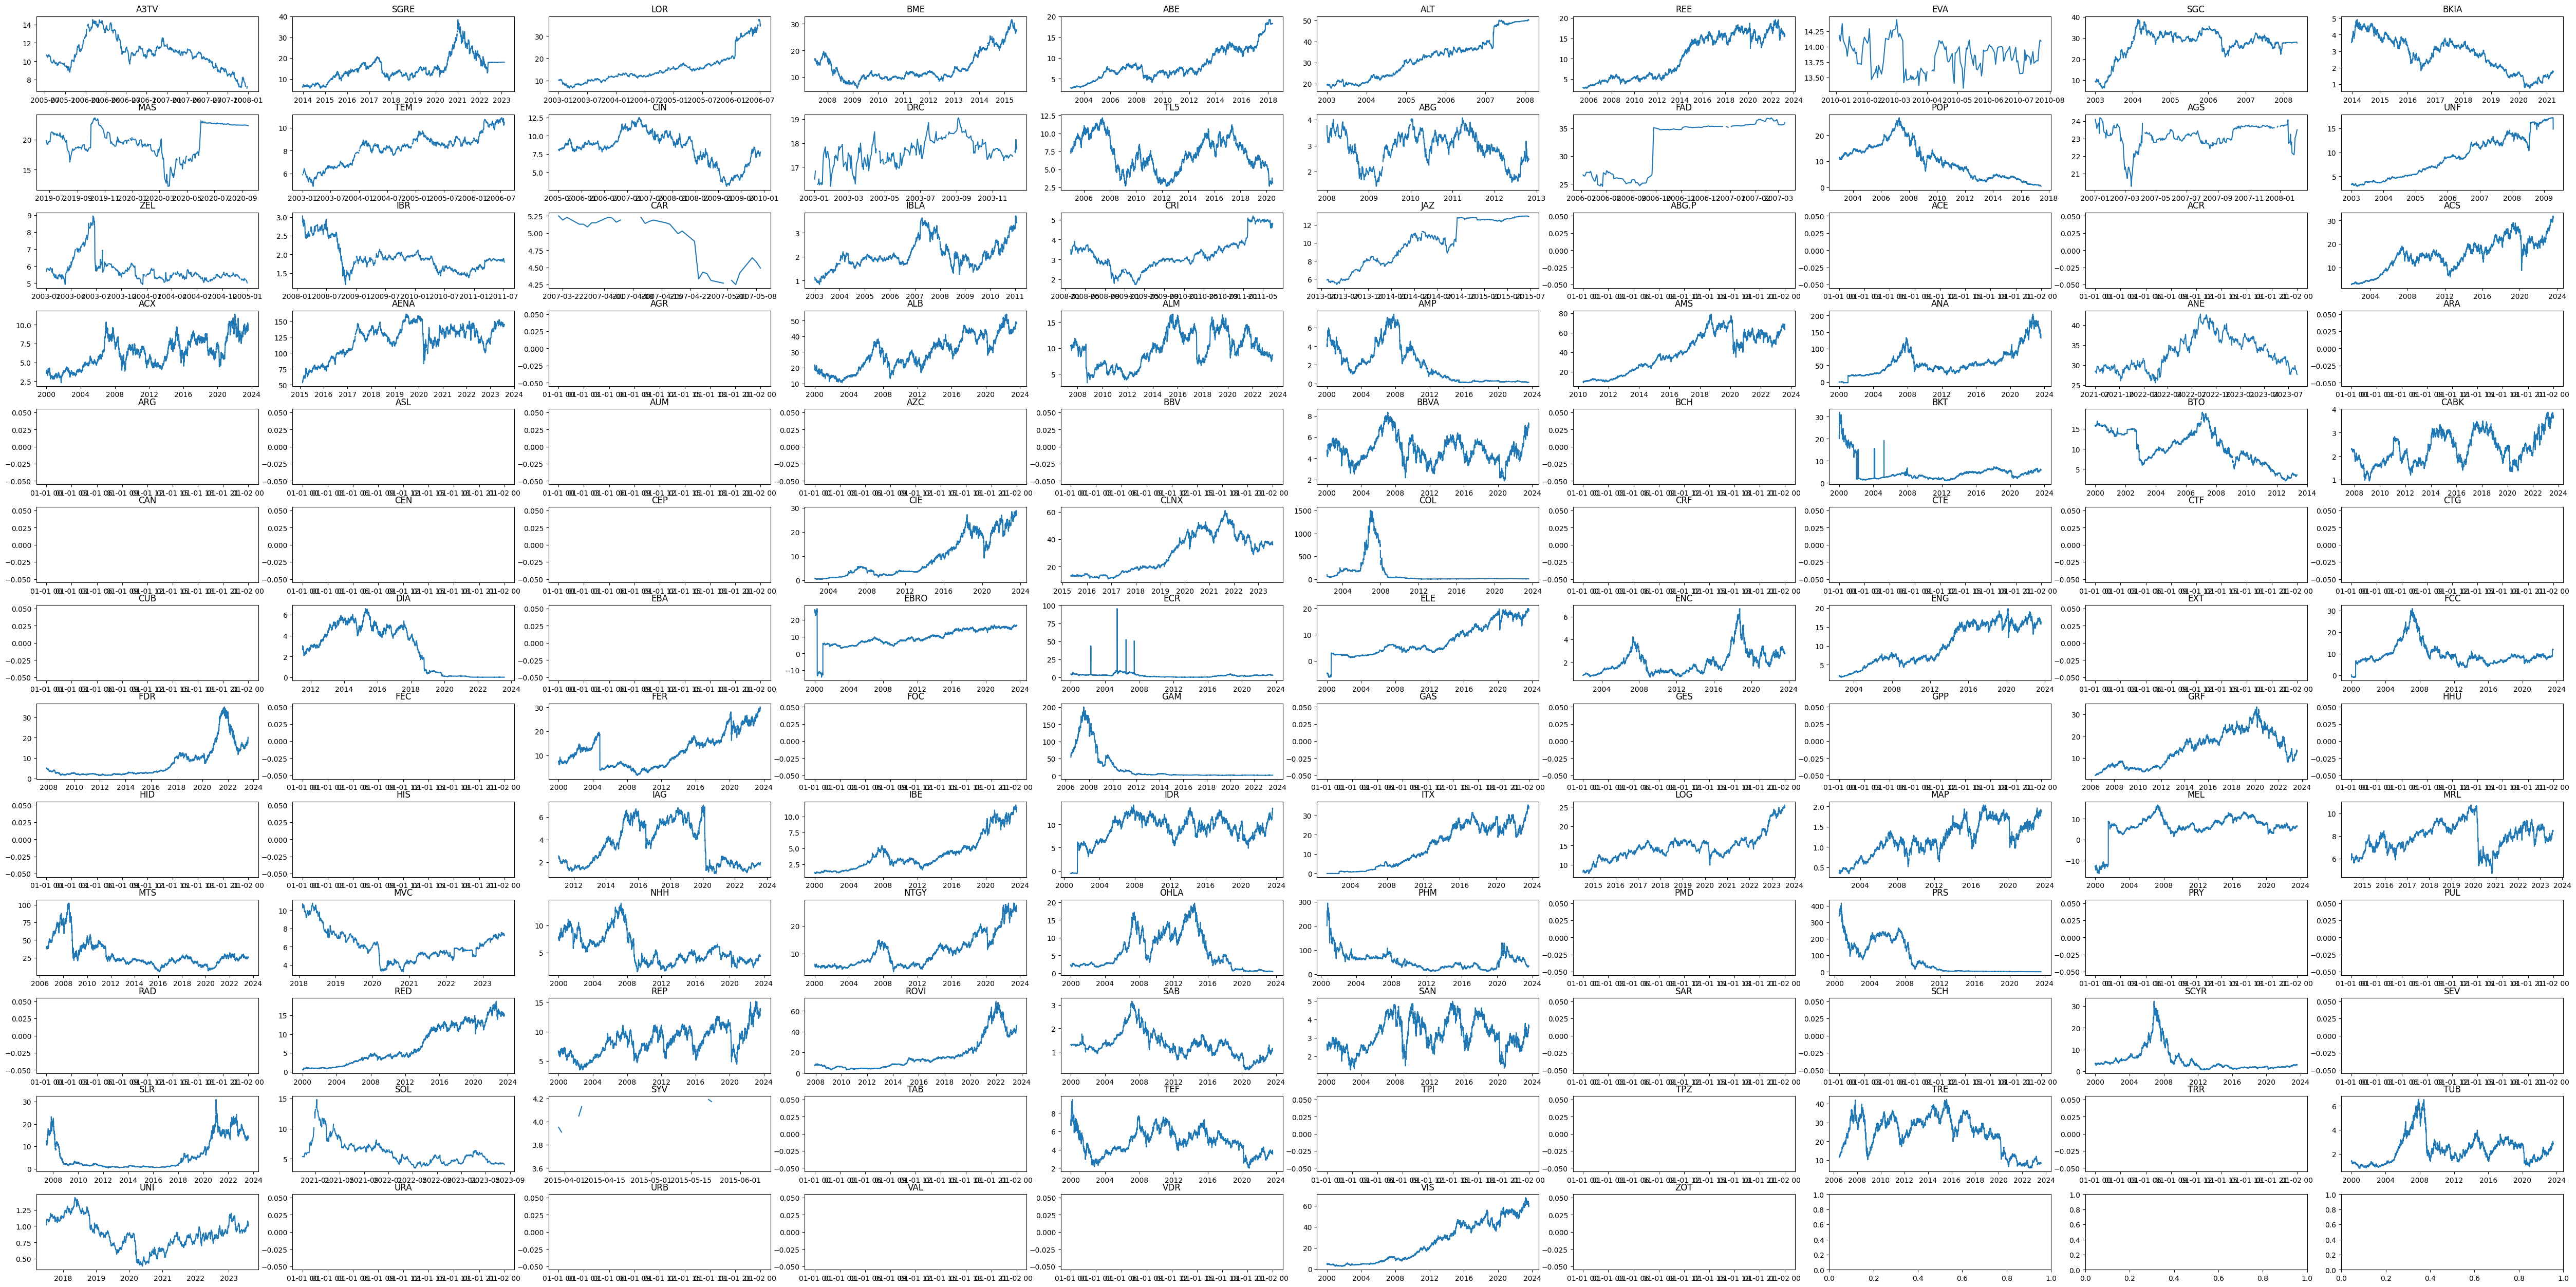

In [170]:
# GRAFICAMOS LOS PRECIOS DE LOS ACTIVOS DESDE TODA LA SERIE HISTORICA
fig, axs = plt.subplots(nrows=13,ncols=10, figsize=(50, 25),)
fig.tight_layout() 
axs = axs.ravel()

for i in range(len(ibex_historical_data.columns)):

    axs[i].plot(ibex_historical_data[ibex_historical_data.columns[i]])
    axs[i].set_title(ibex_historical_data.columns[i])

In [362]:
# CALCULAMOS EL ULTIMO PRECIO MAXIMO AL QUE HA LLEGADO EL ACTIVO EN UNA SERIE HISTORICA
ibex_max_rolling = ibex_historical_data.expanding().max()

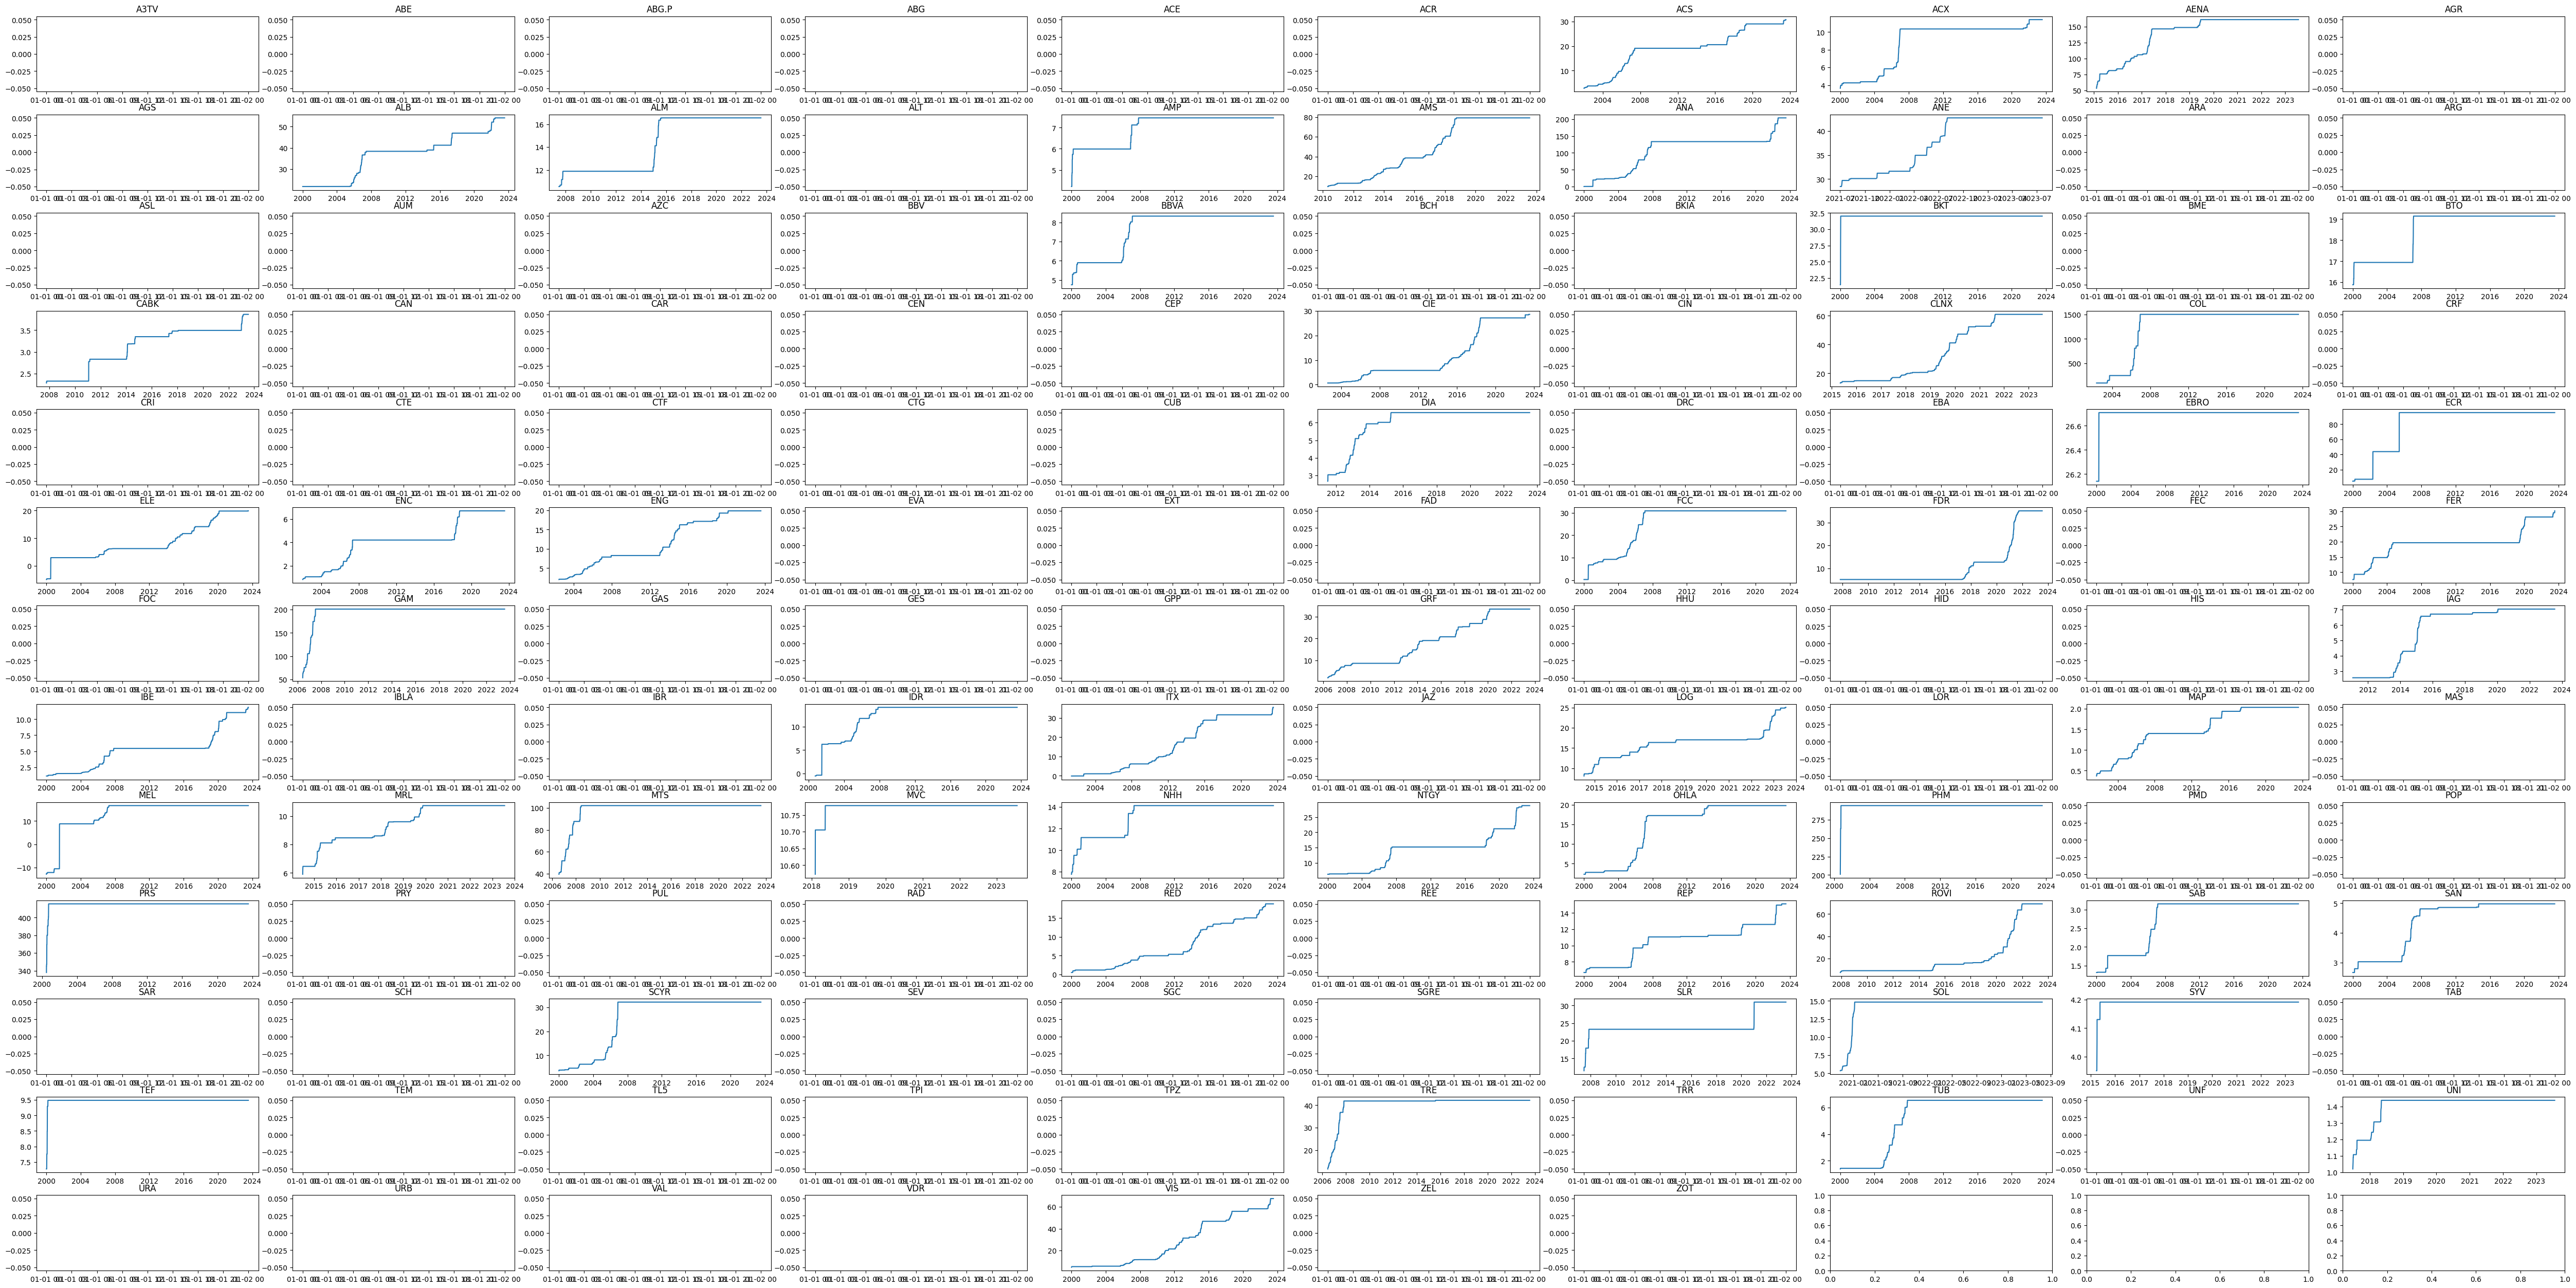

In [363]:
# GRAFICAMOS LA SERIE DE PRECIOS SOLAMENTE CON LOS MAXIMOS
fig, axs = plt.subplots(nrows=13,ncols=10, figsize=(50, 25),)
fig.tight_layout() 
axs = axs.ravel()

for i in range(len(ibex_max_rolling.columns)):

    axs[i].plot(ibex_max_rolling[act_list[i]])
    axs[i].set_title(act_list[i])

In [364]:
# CALCULAMOS EL INDICE DE TIEMPO BAJO EL AGUA
underwater_ibex = (ibex_historical_data / ibex_max_rolling)-1

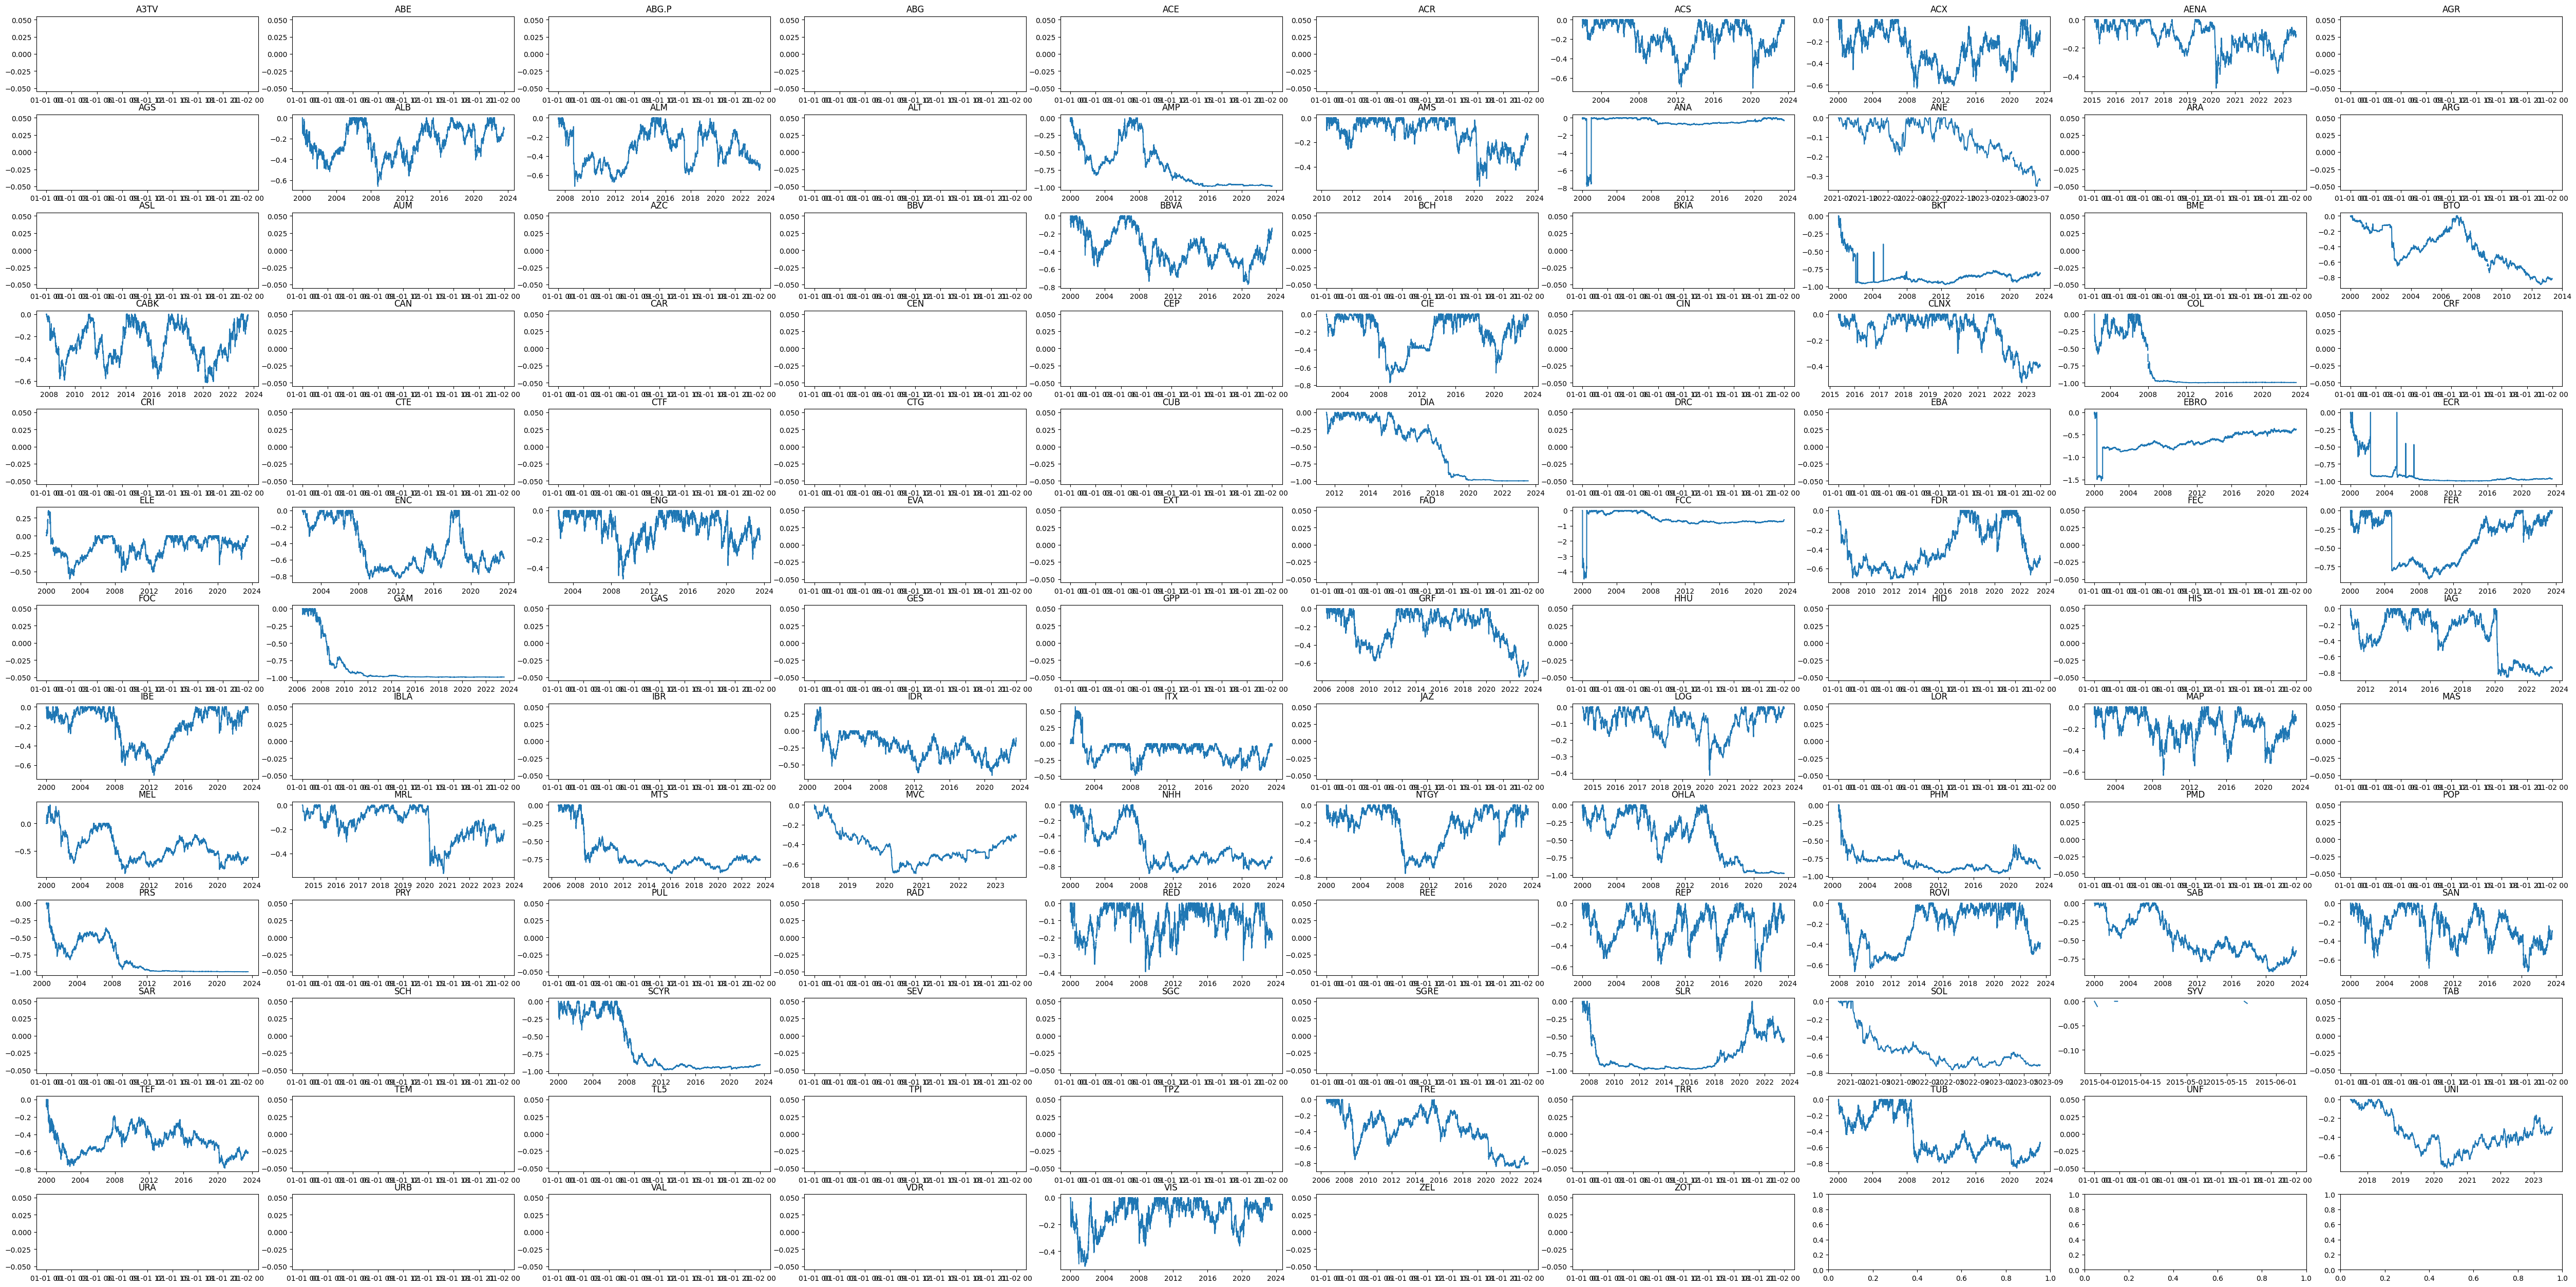

In [365]:
# GRAFICAMOS EL TIEMPO BAJO EL AGUA
fig, axs = plt.subplots(nrows=13,ncols=10, figsize=(50, 25),)
fig.tight_layout() 
axs = axs.ravel()

for i in range(len(underwater_ibex.columns)):

    axs[i].plot(underwater_ibex[act_list[i]])
    axs[i].set_title(act_list[i])

In [227]:
# CALCULAMOS LOS RETORNOS AL CIERRE DE TODOS LOS ACTIVOS
returns = np.log(ibex_historical_data).diff()
returns

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


A3TV  SGRE  LOR  BME  ABE  ALT  REE  EVA  SGC  BKIA  ...  \
1991-02-01   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
1991-02-04   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
1991-02-05   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
1991-02-06   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
1991-02-07   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
...          ...   ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   
2023-07-31   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
2023-08-01   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
2023-08-02   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
2023-08-03   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   
2023-08-04   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...   

                 TRE  TRR       TUB       UNI  URA  URB  VAL  VDR       VIS  \
1991-02-01       NaN  NaN       NaN       NaN  NaN  NaN  NaN  NaN       NaN   
1991-02-04       NaN  NaN       NaN       NaN  NaN  NaN  NaN  NaN       NaN   
1991-02-05       NaN  NaN       NaN       NaN  NaN  NaN  NaN  NaN       NaN   
1991-02-06       NaN  NaN       NaN       NaN  NaN  NaN  NaN  NaN       NaN   
1991-02-07       NaN  NaN       NaN       NaN  NaN  NaN  NaN  NaN       NaN   
...              ...  ...       ...       ...  ...  ...  ...  ...       ...   
2023-07-31 -0.009086  NaN  0.005159 -0.016839  NaN  NaN  NaN  NaN -0.010118   
2023-08-01 -0.017842  NaN -0.019048  0.000943  NaN  NaN  NaN  NaN  0.003384   
2023-08-02 -0.030663  NaN -0.014085 -0.060212  NaN  NaN  NaN  NaN  0.015088   
2023-08-03  0.001197  NaN -0.005333  0.015889  NaN  NaN  NaN  NaN -0.005004   
2023-08-04       NaN  NaN       NaN       NaN  NaN  NaN  NaN  NaN       NaN   

            ZOT  
1991-02-01  NaN  
1991-02-04  NaN  
1991-02-05  NaN  
1991-02-06  NaN  
1991-02-07  NaN  
...         ...  
2023-07-31  NaN  
2023-08-01  NaN  
2023-08-02  NaN  
2023-08-03  NaN  
2023-08-04  NaN  

[8481 rows x 127 columns]

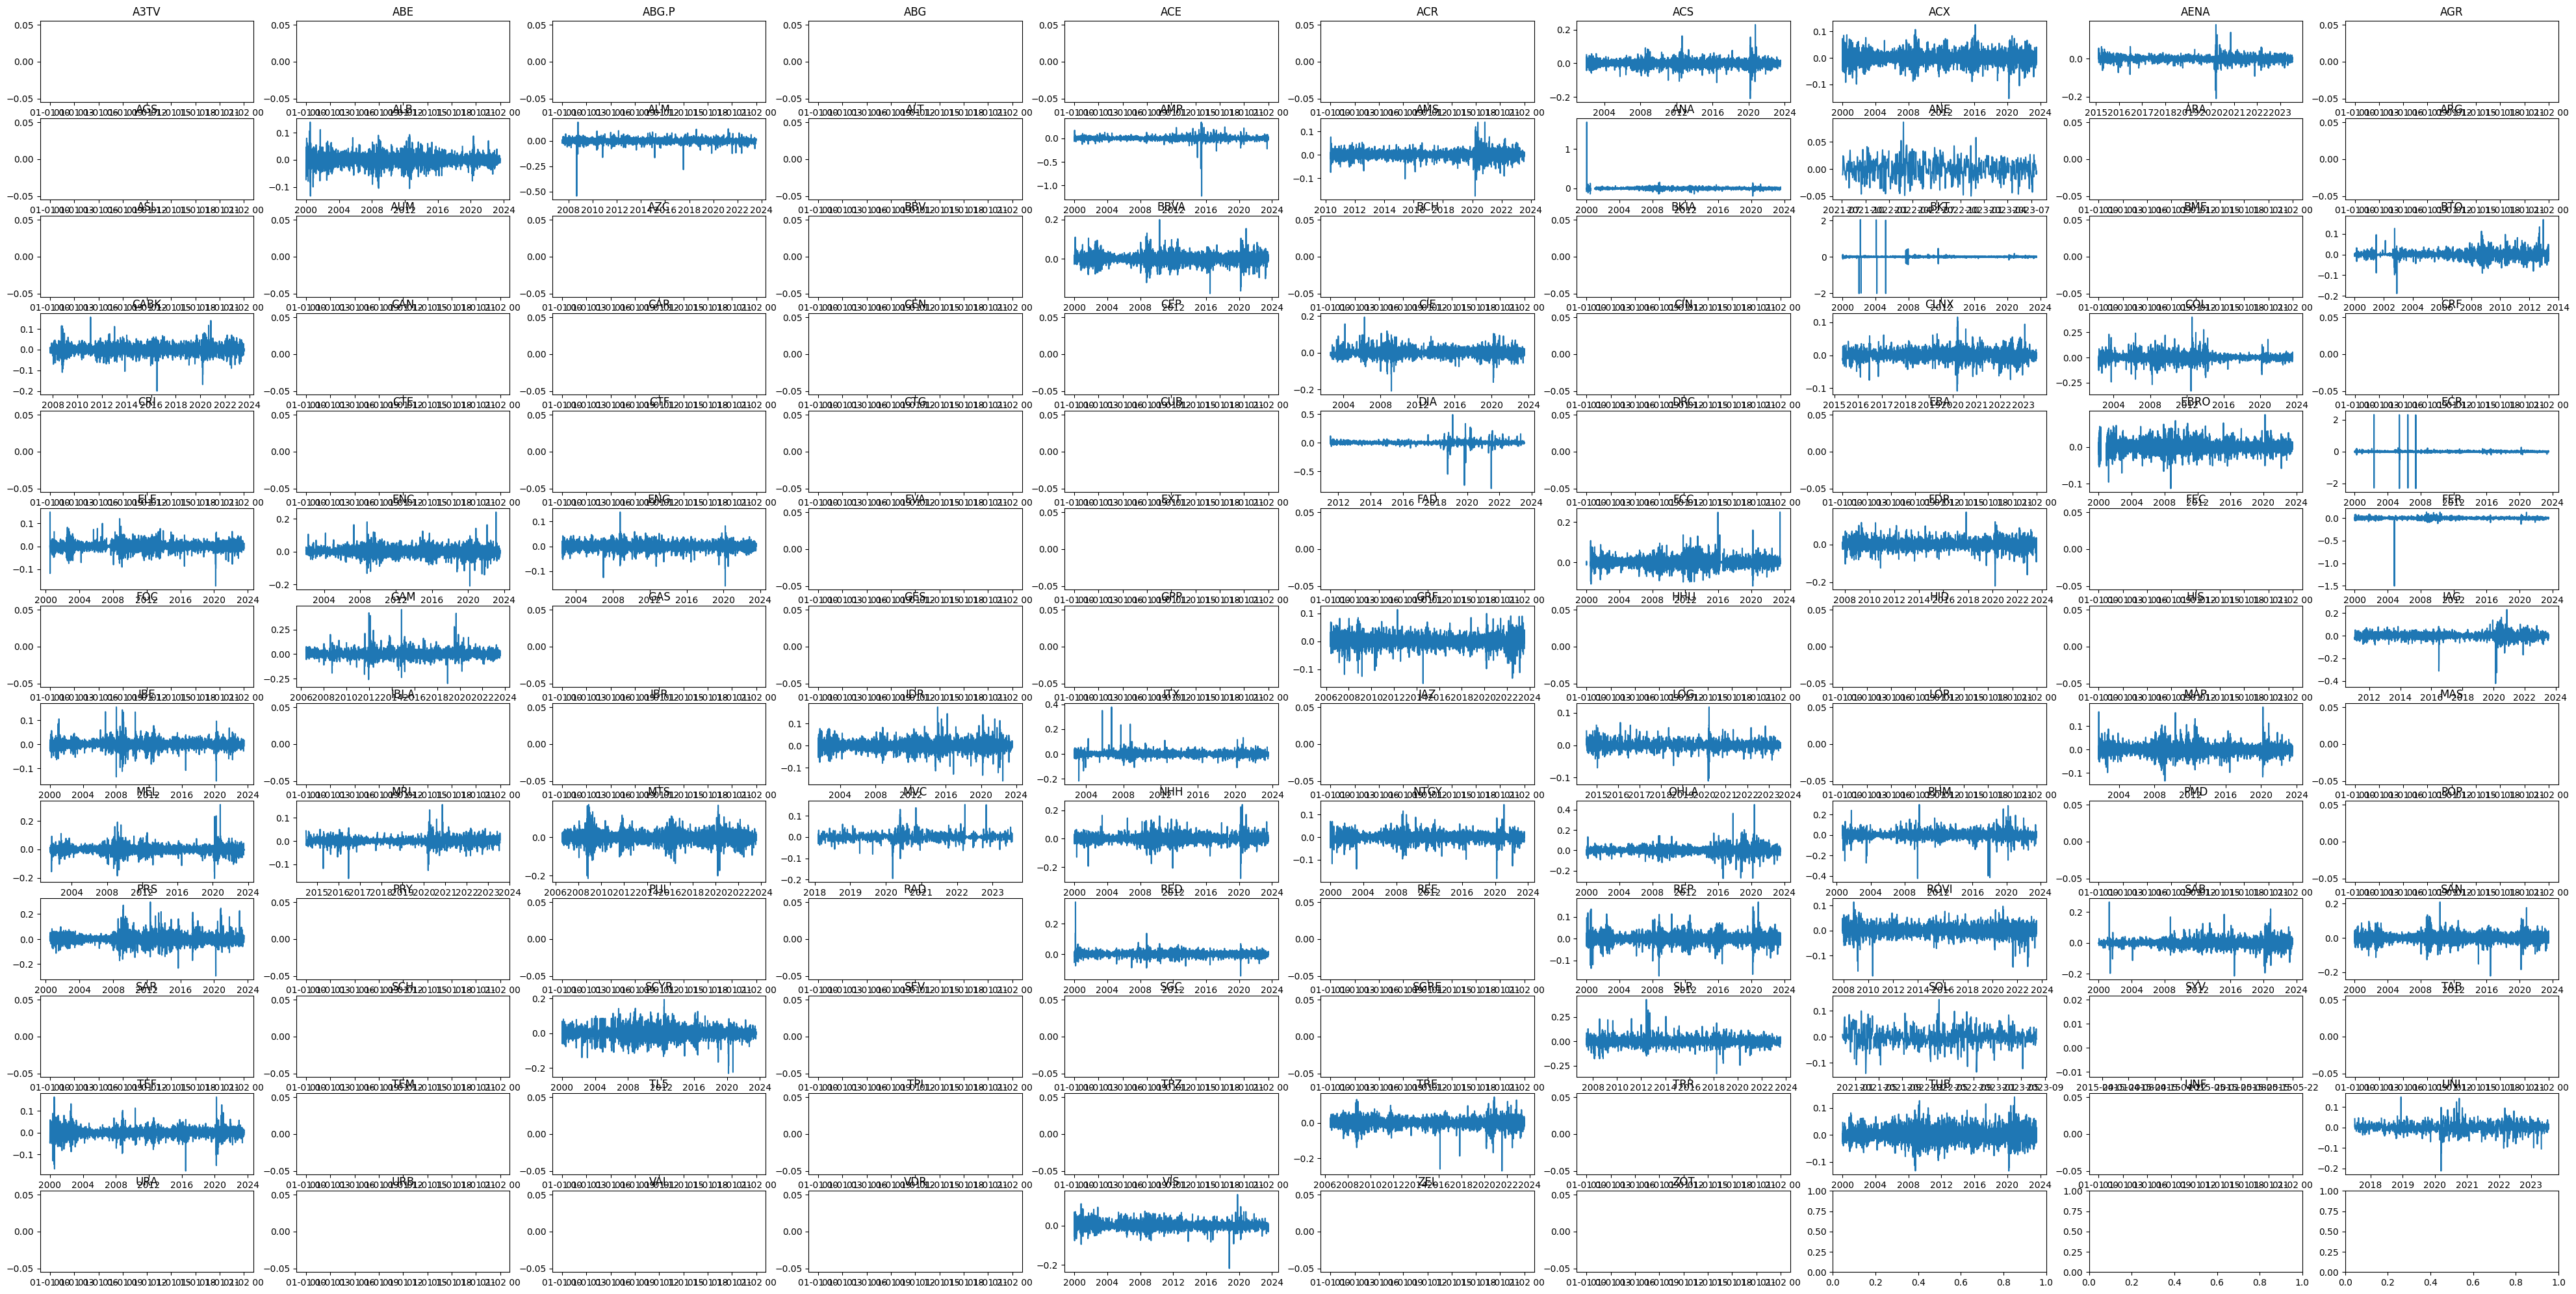

In [369]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=13,ncols=10, figsize=(50, 25))

axs = axs.ravel()

for i in range(len(returns.columns)):

    axs[i].plot(returns[act_list[i]])
    axs[i].set_title(act_list[i])

In [228]:
# BUSCAMOS AQUELLOS ACTIVOS QUE NO TIENEN VALORES EN TODA LA SERIE HISTORICA
null_act = ibex_historical_data.columns[ibex_historical_data.isna().sum() == ibex_historical_data.shape[0]]
null_act

Index(['ABG.P', 'ACE', 'ACR', 'AGR', 'ARA', 'ARG', 'ASL', 'AUM', 'AZC', 'BBV',
       'BCH', 'CAN', 'CEN', 'CEP', 'CRF', 'CTE', 'CTF', 'CTG', 'CUB', 'EBA',
       'EXT', 'FEC', 'FOC', 'GAS', 'GES', 'GPP', 'HHU', 'HID', 'HIS', 'PMD',
       'PRY', 'PUL', 'RAD', 'SAR', 'SCH', 'SEV', 'TAB', 'TPI', 'TPZ', 'TRR',
       'URA', 'URB', 'VAL', 'VDR', 'ZOT'],
      dtype='object')

In [229]:
# HACEMOS UN ANALISIS SOBRE ALGUNAS MÉTRICAS PARA TODOS LOS ACTIVOS
# CALCULAMOS LA BETA PARA CADA ACTIVO
# PARA ESTO NECESITAMOS TAMBIÉN OBTENER EL PRECIO DEL INDICE DE REFERENCIA 
ibex_index = yf.download('^IBEX')['Adj Close']
ibex_index

[*********************100%***********************]  1 of 1 completed


Date
1993-07-12    2826.396973
1993-07-13    2843.396973
1993-07-14    2851.097168
1993-07-15    2843.697021
1993-07-16    2830.497070
                 ...     
2023-07-31    9641.500000
2023-08-01    9502.900391
2023-08-02    9328.700195
2023-08-03    9307.099609
2023-08-04    9309.099609
Name: Adj Close, Length: 7614, dtype: float64

In [230]:
t_bill_files = [filename for filename in os.listdir('./Datos TFM') if filename.startswith("United States 3-Month Bond Yield")]
t_bill_data = pd.DataFrame()
for f in t_bill_files:
    file_path = './Datos TFM/'+f
    file = pd.read_csv(file_path)
    t_bill_data = pd.concat([t_bill_data,file],axis=0)
t_bill_data.index = pd.to_datetime(t_bill_data.Date)
t_bill_data.drop('Date',axis=1,inplace=True)
t_bill_data.head()

Price   Open   High    Low Change %
Date                                           
2023-07-25  5.436  5.432  5.439  5.426    0.34%
2023-07-24  5.418  5.453  5.486  5.418   -0.11%
2023-07-21  5.424  5.445  5.469  5.411    0.15%
2023-07-20  5.416  5.448  5.503  5.409    0.07%
2023-07-19  5.412  5.452  5.452  5.409    0.00%

In [403]:
file_name = 'risk_free_rate.parquet'
full_path = root_path + raw_folder + file_name
risk_free_rate.to_parquet(full_path)

PermissionError: The AWS Access Key Id you provided does not exist in our records.

In [231]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    """
    Calcular el ratio de Sharpe

    Parámetros:
    returns (np.array): Array de rendimientos de la inversión
    risk_free_rate (float): Tasa de rendimiento sin riesgo

    Devuelve:
    sharpe_ratio (float): Ratio de Sharpe
    """

    # Calcular el rendimiento promedio
    avg_returns = np.mean(returns)

    # Calcular la desviación estándar de los rendimientos
    std_returns = np.std(returns)

    # Calcular el ratio de Sharpe
    sharpe_ratio = (avg_returns - risk_free_rate) / std_returns

    return sharpe_ratio

### SCRIPT PARA CALCULAR LA FRONTERA EFICIENTE DE MARKOWITZ

In [ ]:
# PARA HACER:
# - CALCULAR RETORNOS CADA "D" CANTIDAD DE DÍAS                                 DONE
# - CALCULAR RATIO DE SHARPE DE ESTOS RETORNOS                                  DONE
# - ORDENAR POR MAYOR RATIO DE SHARPE (U OTRA METRICA)                          DONE
# - TOMAR N CANTIDAD DE ACTIVOS                                                 DONE
# - SIMULAR N CARTERAS DE ACTIVOS                                               DONE
# - TOMAR MEJOR CARTERA POR RATIO DE SHARPE                                     DONE
# - SIMULAR EJECUCIÓN DE COMPRAS A PRECIO DE CIERRE DEL DIA SIGUIENTE
# - CALCULAR RETORNOS DIARIOS DE LA CARTERA
# - MONITORIZAR POR D CANTIDAD DE DÍAS, STOP LOSS O TAKE PROFIT
# - REPETIR PROCESO

In [239]:
ranking.iloc[1000:]

A3TV  ABE  ABG  ABG.P  ACE  ACR  ACS  ACX  AENA  AGR  ...  TUB  \
1994-11-18     0   93   92     91   90   89   88   87    86   85  ...   40   
1994-11-21     0   93   92     91   90   89   88   87    86   85  ...   40   
1994-11-22     0   93   92     91   90   89   88   87    86   85  ...   40   
1994-11-23     0   93   92     91   90   89   88   87    86   85  ...   40   
1994-11-24     0   93   92     91   90   89   88   87    86   85  ...   40   
...          ...  ...  ...    ...  ...  ...  ...  ...   ...  ...  ...  ...   
2023-07-31     0   93   92     91   90   89   88   87    86   85  ...   40   
2023-08-01     0   93   92     91   90   89   88   87    86   85  ...   40   
2023-08-02     0   93   92     91   90   89   88   87    86   85  ...   40   
2023-08-03     0   93   92     91   90   89   88   87    86   85  ...   40   
2023-08-04     0   93   92     91   90   89   88   87    86   85  ...   40   

            UNF  UNI  URA  URB  VAL  VDR  VIS  ZEL  ZOT  
1994-11-18   39   38   37   36   35   34   33  126  127  
1994-11-21   39   38   37   36   35   34   33  126  127  
1994-11-22   39   38   37   36   35   34   33  126  127  
1994-11-23   39   38   37   36   35   34   33  126  127  
1994-11-24   39   38   37   36   35   34   33  126  127  
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  
2023-07-31   39   38   37   36   35   34   33  126  127  
2023-08-01   39   38   37   36   35   34   33  126  127  
2023-08-02   39   38   37   36   35   34   33  126  127  
2023-08-03   39   38   37   36   35   34   33  126  127  
2023-08-04   39   38   37   36   35   34   33  126  127  

[7583 rows x 127 columns]

In [240]:
# DEFINIMOS UNA CANTIDAD DE DIAS PARA LA VENTANA DE CALCULO DE LOS RETORNOS
DIAS = 10
ACTIVOS = 10
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = t_bill_data['Price']/100
# CALCULAMOS LA SUMA DE RETORNOS CON ESA VENTANA DE DIAS DEFINIDA
period_returns = returns.rolling(DIAS, min_periods=0).sum()
period_returns = pd.concat([period_returns, risk_free_rate], axis=1)
risk_free_rate = period_returns['Price']
period_returns_std = returns.rolling(DIAS, min_periods=0).std()

adjusted_period_returns = (period_returns.transpose() - risk_free_rate).transpose()
sharpe_ratio = adjusted_period_returns / period_returns_std
ranking = np.argsort(-sharpe_ratio,).drop('Price',axis=1)

In [246]:
returns.iloc[3000].sort_values(ascending=True,na_position='last')

MEL   -0.046440
ACS   -0.030585
IDR   -0.028760
ECR   -0.025318
VIS   -0.024524
         ...   
URA         NaN
URB         NaN
VAL         NaN
VDR         NaN
ZOT         NaN
Name: 2002-08-02 00:00:00, Length: 127, dtype: float64

In [254]:
truncated_ranking = ranking.iloc[3000].sort_values(ascending=False,na_position='last')[:ACTIVOS]
sharpe_ratio.loc['2002-08-02',truncated_ranking.index.values]

ZOT          NaN
SLR          NaN
ABE          NaN
DRC          NaN
EBA          NaN
EBRO   -5.679759
ECR    -1.355945
ELE    -2.161754
ENC    -3.884644
ACR          NaN
Name: 2002-08-02 00:00:00, dtype: float64

In [501]:
sharpe_ratio.dropna(how='all',axis=0,inplace=True)

In [581]:
sharpe_ratio[truncated_ranking.index]

CRI       RED  RAD  PUL  PRY       PRS  ALT  POP  PMD       PHM
2000-01-05  NaN -1.962911  NaN  NaN  NaN       NaN  NaN  NaN  NaN       NaN
2000-01-06  NaN -1.955156  NaN  NaN  NaN       NaN  NaN  NaN  NaN       NaN
2000-01-07  NaN -1.951384  NaN  NaN  NaN       NaN  NaN  NaN  NaN       NaN
2000-01-10  NaN -2.617899  NaN  NaN  NaN       NaN  NaN  NaN  NaN       NaN
2000-01-11  NaN -3.140032  NaN  NaN  NaN       NaN  NaN  NaN  NaN       NaN
...         ...       ...  ...  ...  ...       ...  ...  ...  ...       ...
2023-07-17  NaN -9.213457  NaN  NaN  NaN -2.376950  NaN  NaN  NaN -0.660253
2023-07-18  NaN -9.196531  NaN  NaN  NaN -2.251976  NaN  NaN  NaN  0.191226
2023-07-19  NaN -5.079647  NaN  NaN  NaN -3.012366  NaN  NaN  NaN  2.970963
2023-07-20  NaN -3.625156  NaN  NaN  NaN -1.786468  NaN  NaN  NaN  4.449263
2023-07-21  NaN -1.989629  NaN  NaN  NaN -1.462073  NaN  NaN  NaN  4.017978

[6005 rows x 10 columns]

In [304]:
ACTIVOS = 10
PORTFOLIOS = 10000
ranking = np.argsort(-sharpe_ratio).drop('Price',axis=1)

# SIMULACION DE ACTIVIDAD DE MERCADO
# PARA CADA DIA DEBO ANALIZAR EL RANKING DADO
for i in ranking.index[3000:3001]:

    # DEBO TOMAR A CANTIDAD DE ACTIVOS CON MAYOR RATIO DE SHARPE
    truncated_ranking = ranking.loc[i].sort_values(ascending=True,na_position='last')[:ACTIVOS]
    simulacion = pd.DataFrame(columns=['r_p', 'std_p', *truncated_ranking.index], index=range(PORTFOLIOS))
    # DEBO SIMULAR P CANTIDAD DE PORTFOLIOS
    for p in range(PORTFOLIOS):
        # DEBO CALCULAR EL RATIO DE SHARPE DE CADA PORTFOLIO
        w = np.random.rand(1,len(truncated_ranking.index))
        w = w / w.sum()
        w_transposed = w.T

        ret = adjusted_period_returns.loc[i,truncated_ranking.index]
        sigma = returns.loc[i:i+datetime.timedelta(days=10),truncated_ranking.index].cov().fillna(0)

        r_p = ret @ w_transposed
        s_p = np.sqrt(w @ sigma @ w_transposed)
        # r_p = np.dot(w,ret)
        # s_p = np.sqrt(np.dot(np.dot(w,sigma),w_transposed))
        simulacion.loc[p,"r_p"] = r_p[0]
        simulacion.loc[p,"std_p"] = s_p[0][0]
        simulacion.iloc[p,2:] = w
        print(simulacion.iloc[p])
    simulacion['sharpe'] = simulacion.loc[:, 'r_p'] / simulacion.loc[:, 'std_p']
    r_port_sharpe = simulacion.iloc[np.argmax(simulacion.sharpe)]
    print(r_port_sharpe)
    

r_p     -0.038137
std_p    0.012687
CUB      0.191973
REP      0.075838
REE      0.098484
RED      0.066017
RAD      0.049505
ALM      0.229628
BBVA     0.134136
PUL      0.044478
PRY       0.02776
PRS      0.082181
Name: 0, dtype: object
r_p     -0.020294
std_p    0.014754
CUB      0.086433
REP      0.072317
REE      0.023733
RED         0.094
RAD      0.137046
ALM      0.162274
BBVA     0.107822
PUL      0.015425
PRY       0.07612
PRS       0.22483
Name: 1, dtype: object
r_p     -0.058346
std_p    0.018472
CUB      0.065487
REP      0.179884
REE      0.030045
RED      0.170635
RAD      0.156056
ALM      0.010549
BBVA     0.149055
PUL      0.134604
PRY      0.099288
PRS      0.004397
Name: 2, dtype: object
r_p     -0.019402
std_p    0.009065
CUB      0.128775
REP      0.026879
REE      0.078012
RED       0.21718
RAD      0.142106
ALM      0.194486
BBVA     0.027009
PUL      0.023479
PRY      0.037204
PRS      0.124869
Name: 3, dtype: object
r_p     -0.029059
std_p    0.012439
CUB     

In [306]:
r_port_sharpe

r_p       0.010552
std_p     0.012285
CUB       0.067029
REP       0.020431
REE       0.076066
RED       0.013622
RAD       0.112594
ALM       0.016577
BBVA      0.037681
PUL       0.066915
PRY       0.235221
PRS       0.353864
sharpe    0.858946
Name: 2247, dtype: object

### SCRIPT PARA CALCULAR LA FRONTERA EFICIENTE DE MARKOWITZ

In [ ]:
portfolios = 10000
simulacion = pd.DataFrame(columns=["retorno_portfolio","desv_tip_portfolio",df.columns],index=range(portfolios))

for portfolio in range(portfolios):
    w = random.rand(1,df.shape[1])
    w = w / w.sum()
    retornos = df.pct_change()
    mu = retornos.mean()
    sigma = retornos.cov()
    w_transposed = w.T
    r_p = np.dot(w,mu)
    s_p = np.sqrt(np.dot(np.dot(w,sigma),w_transposed))
    simulacion.loc[portfolio,"retorno_portfolio"] = r_p
    simulacion.loc[portfolio,"desv_tip_portfolio"] = s_p
    simulacion.iloc[portfolio,2:] = w

In [ ]:
simulacion.plot.scatter(x="desv_tip_portfolio",y="retorno_portfolio")
plt.show()

In [ ]:
portfolios = 10000
simulacion = pd.DataFrame(columns=["retorno_portfolio","desv_tip_portfolio",df.columns],index=range(portfolios))

for portfolio in range(portfolios):
    w = random.rand(1,df.shape[1])
    w = w / w.sum()
    retornos = df.pct_change()
    mu = retornos
    sigma = retornos.cov()
    w_transposed = w.T
    r_p = np.dot(w,mu) - 
    s_p = np.sqrt(np.dot(np.dot(w,sigma),w_transposed))
    simulacion.loc[portfolio,"retorno_portfolio"] = r_p
    simulacion.loc[portfolio,"desv_tip_portfolio"] = s_p
    simulacion.iloc[portfolio,2:] = w

In [ ]:
simulacion.plot.scatter(x="desv_tip_portfolio",y="retorno_portfolio")
plt.show()

### SCRIPT PARA HACER BACKTESTING

In [ ]:
init_capital = 100_000

In [ ]:
delta_cash = pd.Series(0, index=stock_df.index)
delta_cash.iloc[0] = init_capital
delta_shares = pd.DataFrame(0, index=stock_df.index, columns=stock_df.columns)

for idate, isignals in all_signals.iterrows():    
    daybuys = isignals[isignals == 1]
    daysells = isignals[isignals == -1]
    
    if daybuys.count() == 0 and daysells.count() == 0:
        continue

    # actualizar portfolio 
    cash = delta_cash.cumsum()
    posiciones = delta_shares.cumsum()
    valoracion = posiciones * stock_df
    inversiones = valoracion.sum(axis=1)
    equity = inversiones + cash
    
    day_cash = cash.loc[idate]
    # limite de asignación a un 10% de la cartera
    alloc_limit = equity.loc[idate] * 0.1

    in_money, out_money = 0, 0
    # compras
    if daybuys.count() > 0:
        tk_money = min(day_cash/daybuys.count(), alloc_limit)
        buy_shares = np.floor(tk_money/open_df.loc[idate, daybuys.index])
        out_money = (buy_shares * open_df.loc[idate, daybuys.index]).sum()
        delta_shares.loc[idate, daybuys.index] = buy_shares

    # ventas
    if daysells.count() > 0:
        sell_shares = posiciones.loc[idate, daysells.index]
        in_money = (sell_shares * open_df.loc[idate, daysells.index]).sum()
        delta_shares.loc[idate, daysells.index] = -sell_shares

    delta_cash.loc[idate] = in_money - out_money

In [ ]:
# ultima actualizacion
cash = delta_cash.cumsum()
posiciones = delta_shares.cumsum()
valoracion = posiciones * stock_df
inversiones = valoracion.sum(axis=1)
equity = inversiones + cash

In [ ]:
show_df = pd.DataFrame({
    'inversiones': inversiones,
    'efectivo': cash,
    'patrimonio': equity
})
show_df.plot(figsize=(10,6))

In [ ]:
show_df.tail()

In [ ]:
bm = benchmark.reindex(stock_df.index)
pasive_invest = init_capital*(bm/bm.iloc[0])

In [ ]:
compare_df = pd.DataFrame({
    'SMA': equity,
    'benchmark': pasive_invest
})

compare_df.plot(figsize=(10,6))

## SOLO PARA TESTEAR WEBSCRAPING DE INVESTING

In [63]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time

In [79]:
driver = webdriver.Chrome()
driver.get('https://www.investing.com/')
time.sleep(1)
button = driver.find_element(By.ID,'onetrust-accept-btn-handler')
button.click()
input = driver.find_element(By.CSS_SELECTOR,'body > div.wrapper > header > div.topBar > div > div.searchDiv.newSearchDiv.js-main-search-wrapper > div.searchBoxContainer.topBarSearch.topBarInputSelected > input')
input.send_keys('ACX')
time.sleep(1)
first_selection = driver.find_element(By.CLASS_NAME,"row.js-quote-row-template.js-quote-item")
first_selection.click()
driver.maximize_window()
html = driver.find_element(By.TAG_NAME, 'html')
html.send_keys(Keys.PAGE_DOWN)
time.sleep(1)
historical_data = driver.find_element(By.XPATH,'//*[@id="__next"]/div[2]/div/div/div[2]/main/div[1]/div[7]/nav/ul/li[3]/a')
historical_data.click()
start_date = ibex_constituents.loc[ibex_constituents['Activo']=='ACX']['Inclusion']
end_date = ibex_constituents.loc[ibex_constituents['Activo']=='ACX']['Exclusion']
html = driver.find_element(By.TAG_NAME, 'html')
html.send_keys(Keys.PAGE_DOWN)
date_entry = driver.find_element(By.CLASS_NAME,"DatePickerWrapper_input-text__PDRoD.DatePickerWrapper_center__zPpJy")
date_entry.click()
start_date_entry = driver.find_element(By.XPATH,'NativeDateInput_root__wbgyP')
start_date_entry.send_keys(start_date)
end_date_entry = driver.find_element(By.CLASS_NAME,"NativeDateInput_root__wbgyP")
end_date_entry.send_keys(end_date)

# Obtain the number of rows in body
rows = 1+len(driver.find_elements(By.XPATH,
    "//*[@id=\"__next\"]/div[2]/div/div/div[2]/main/div/div[8]/div/div/div[3]/div/table"))
 
# Obtain the number of columns in table
cols = len(driver.find_elements(By.XPATH,
    "//*[@id=\"__next\"]/div[2]/div/div/div[2]/main/div/div[8]/div/div/div[3]/div/table"))
 
# Print rows and columns
print(rows)
print(cols)
 
# Printing the table headers
print("Locators           "+"             Description")
 
# Printing the data of the table
for r in range(2, rows+1):
    for p in range(1, cols+1):
       
        # obtaining the text from each column of the table
        value = driver.find_element(By.XPATH,
            "//*[@id=\"__next\"]/div[2]/div/div/div[2]/main/div/div[8]/div/div/div[3]/div/table/tbody/tr["+str(r)+"]/td["+str(p)+"]").text
        print(value, end='       ')
    print()

ElementClickInterceptedException: Message: element click intercepted: Element <div class="DatePickerWrapper_input-text__PDRoD DatePickerWrapper_center__zPpJy">...</div> is not clickable at point (821, 370). Other element would receive the click: <td class="datatable_cell__0y0eu datatable_cell--align-end__fwomz datatable_cell--up__Gt_ed font-bold" dir="ltr">...</td>
  (Session info: chrome=112.0.5615.121)
Stacktrace:
Backtrace:
	GetHandleVerifier [0x0053DCE3+50899]
	(No symbol) [0x004CE111]
	(No symbol) [0x003D5588]
	(No symbol) [0x00405A7A]
	(No symbol) [0x00404336]
	(No symbol) [0x0040267B]
	(No symbol) [0x00401797]
	(No symbol) [0x003F94A5]
	(No symbol) [0x0041B8FC]
	(No symbol) [0x003F8EC6]
	(No symbol) [0x0041BC54]
	(No symbol) [0x0042E01C]
	(No symbol) [0x0041B6F6]
	(No symbol) [0x003F7708]
	(No symbol) [0x003F886D]
	GetHandleVerifier [0x007A3EAE+2566302]
	GetHandleVerifier [0x007D92B1+2784417]
	GetHandleVerifier [0x007D327C+2759788]
	GetHandleVerifier [0x005D5740+672048]
	(No symbol) [0x004D8872]
	(No symbol) [0x004D41C8]
	(No symbol) [0x004D42AB]
	(No symbol) [0x004C71B7]
	BaseThreadInitThunk [0x75A57D59+25]
	RtlInitializeExceptionChain [0x77BCB74B+107]
	RtlClearBits [0x77BCB6CF+191]


In [47]:
import json
import datetime
import requests 
from bs4 import BeautifulSoup


url = 'https://www.investing.com/'
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0',
    'X-Requested-With': 'XMLHttpRequest',
    'Referer': 'https://www.investing.com/'}
data = requests.get(url, headers=headers).json()

# uncomment this to print all data:
# print( json.dumps(data, indent=4) )

for candle in data['candles']:
    t = datetime.datetime.fromtimestamp(candle[0] // 1000)
    print('{!s:<20} {:<10} {:<10} {:<10}'.format(t, *candle[1:]))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)